In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("proteun4", "AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS")
]

In [2]:
print(alphabet)


In [3]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [4]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[32], return_contacts=True)
token_representations = results["representations"][32]

In [5]:
token_representations[0].shape

torch.Size([288, 1280])

In [6]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    print(token_representations[i].shape)

torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])


In [7]:
sequence_representations

[tensor([ 4.6987, -2.3694, -0.3084,  ..., -4.0112, -3.2634, -1.0328]),
 tensor([ 4.4958, -0.9851,  2.9237,  ..., -4.4470, -1.6426, -0.5239]),
 tensor([ 5.2587, -1.3039,  2.9077,  ..., -4.9862, -0.4840, -1.0121]),
 tensor([ -1.7384,  -6.8481,   5.2880,  ...,  -4.2909,   4.1356, -13.5250]),
 tensor([ 1.7132,  3.1321, -2.3060,  ...,  3.1544,  2.6045,  2.5149])]

## Attention representation

We may have more information if we can do the regression from the attention matrix.
The issue is that the size of the attention matrix depends on the length of the sequence. It could be that we could use the entire length that has zeros but then the regression model may get biased toward that.

How to go for a varying length attention representation to a regression??

torch.Size([286, 286])


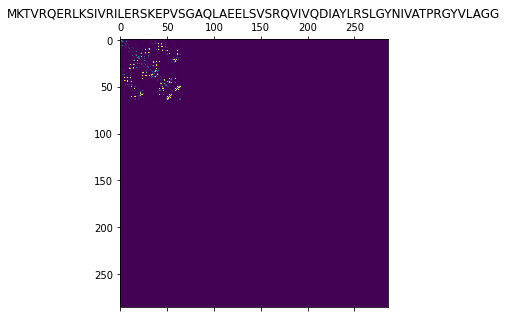

torch.Size([286, 286])


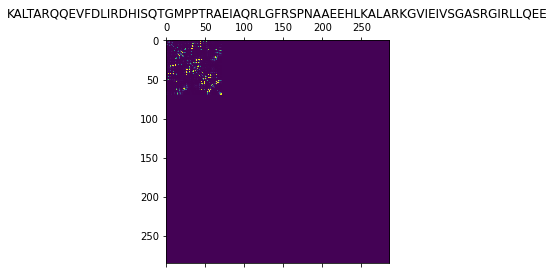

torch.Size([286, 286])


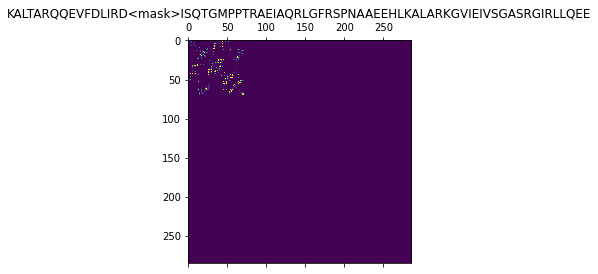

torch.Size([286, 286])


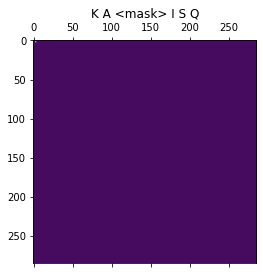

torch.Size([286, 286])


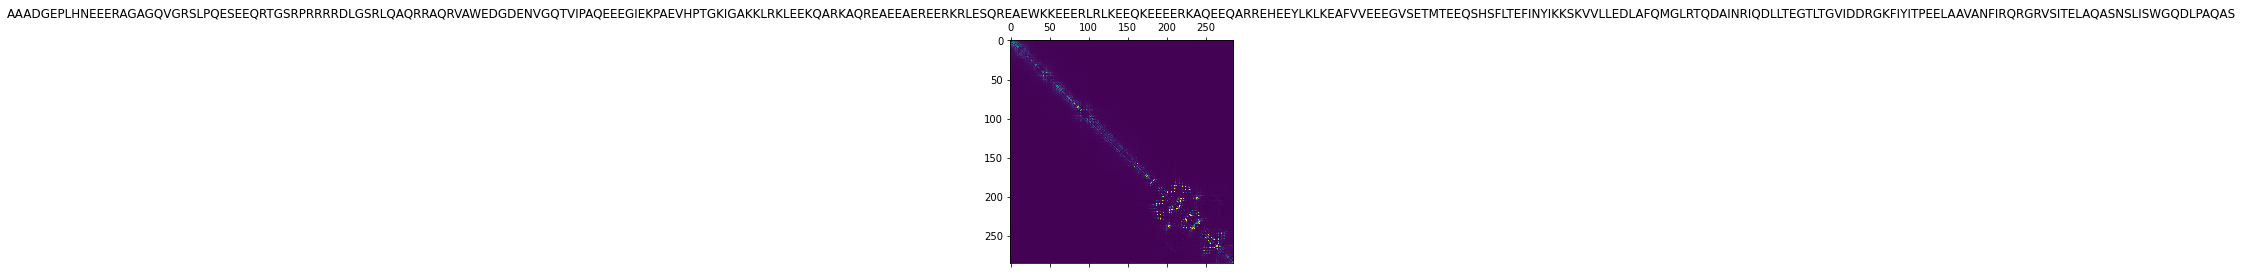

In [8]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    #plt.matshow(attention_contacts[: len(seq), : len(seq)])
    print(attention_contacts.shape)
    plt.matshow(attention_contacts[: , : ])
    plt.title(seq)
    plt.show()

In [9]:
print(results.keys())

dict_keys(['logits', 'representations', 'attentions', 'contacts'])


In [10]:
logits = results['representations']

In [11]:
print(logits[32].shape)

torch.Size([5, 288, 1280])


In [12]:
print(model)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [13]:
print(alphabet)

## Sequence embedding

The paper suggest to average all the hidden states and come to an embedding for the sequence. That is definately the first thing that we can try, but we may be losing some important information. 

We first try this.

In [14]:
newdata = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
]

In [15]:
batch_labels, batch_strs, batch_tokens = batch_converter(newdata)

In [16]:
with torch.no_grad():
    newresults = model(batch_tokens, repr_layers=[32], return_contacts=True)
    
token_representations = newresults["representations"][32]

In [17]:
token_representations.shape

torch.Size([1, 67, 1280])

In [18]:
sequence_representations[0]

tensor([ 4.6987, -2.3694, -0.3084,  ..., -4.0112, -3.2634, -1.0328])

In [19]:
import pandas as pd

In [20]:
df_train = pd.read_csv("./proteindata/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./proteindata/train_updates_20220929.csv", index_col="seq_id")

In [21]:
df_train.shape

(31390, 4)

In [22]:
all_features_nan = df_train_updates.isnull().all("columns")

In [23]:
drop_indices = df_train_updates[all_features_nan].index

In [24]:
drop_indices

Int64Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,
               78,
            ...
            29682, 29787, 29788, 29852, 29853, 30738, 30739, 30740, 30741,
            30742],
           dtype='int64', name='seq_id', length=2409)

In [25]:
df_train = df_train.drop(index=drop_indices)

In [26]:
df_train.shape

(28981, 4)

In [27]:
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [28]:
data = df_train

In [29]:
data.shape

(28981, 4)

In [30]:
x = data['protein_sequence'].tolist()

In [31]:
y = data['tm'].tolist()

In [32]:
ph = data['pH'].tolist()

In [33]:
len(x), len(y), len(ph)

(28981, 28981, 28981)

## Cleaning the training data

I suspect that the protein length > 1000 would not be good for the model. Test data sequence is around 200 in length.
I also think the ESM model does not accept such long sequences. Not sure but I think max is 1024, need to check so we can filter the data and discard longer > 1024 size sequences.


Also filtering for very short sequences < 40... just arbitrary we can change

In [34]:
import math
train_x = []
train_y = []
train_ph = []

for sequence, tm, pH in zip(x, y, ph):
    if math.isnan(pH):
        continue
    if len(sequence) >= 20 and len(sequence) <= 620:
        #if tm < 25 or tm >= 105:
        #    continue
        train_x.append(sequence)
        train_y.append(tm)
        train_ph.append(pH)

In [35]:
x[1]

'AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS'

In [36]:
y[1]

50.5

In [37]:
ph[1]

7.0

In [38]:
len(train_x), len(train_y), len(train_ph)

(23175, 23175, 23175)

In [39]:
sequence_lengths = [len(sequence) for sequence in x]

In [40]:
sequence_lengths[0]

341

In [41]:
import numpy as np
import matplotlib.pyplot as plt

(array([1110., 5588., 5225., 4743., 4117., 2302., 1515., 1060.,  756.,
         619.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

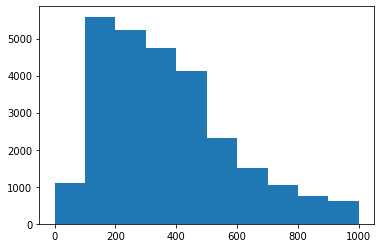

In [42]:
plt.hist(sequence_lengths, range = (0, 1000))

(array([1576.,  277.,   50.,   22.,   17.,    3.,    2.,    3.,    2.,
           0.]),
 array([ 1000.,  1900.,  2800.,  3700.,  4600.,  5500.,  6400.,  7300.,
         8200.,  9100., 10000.]),
 <BarContainer object of 10 artists>)

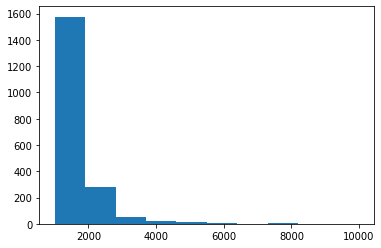

In [43]:
plt.hist(sequence_lengths, range = (1000, 10000))

(array([  3.,   5.,   8.,  13.,  24., 104., 237., 119., 231., 452.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

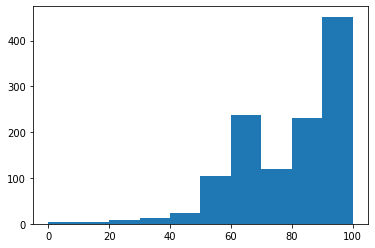

In [44]:
plt.hist(sequence_lengths, range = (0, 100))

In [45]:
len(train_x), len(train_y), len(train_ph)

(23175, 23175, 23175)

In [46]:
train_sequence_lengths = [len(sequence) for sequence in train_x]

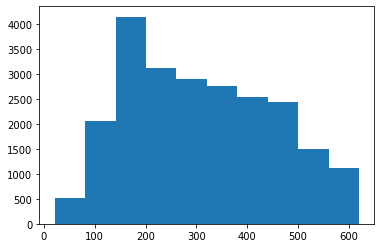

In [47]:
plt.hist(train_sequence_lengths)
plt.show()

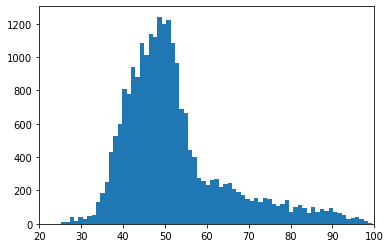

In [48]:
plt.hist(train_y,100)
plt.xlim([20, 100])
plt.show()

# New Split BEFORE STRATIFYING

In [49]:
len(train_x), len(train_y), len(train_ph)

(23175, 23175, 23175)

In [50]:
train_x_ph = [[x, ph] for (x, ph) in zip(train_x, train_ph)]

In [51]:
data_x_ph, data_y = train_x_ph, train_y

In [52]:
from sklearn.model_selection import train_test_split
train_x_ph, test_x_ph, train_y, test_y = train_test_split(data_x_ph, data_y, test_size=0.015, random_state=42, shuffle = True)

In [53]:
len(train_x_ph), len(train_y)

(22827, 22827)

In [54]:
len(test_x_ph), len(test_y)

(348, 348)

In [55]:
train_x = [x_ph[0] for x_ph in train_x_ph]

In [56]:
train_ph = [x_ph[1] for x_ph in train_x_ph]

In [57]:
test_x = [x_ph[0] for x_ph in test_x_ph]

In [58]:
test_ph = [x_ph[1] for x_ph in test_x_ph]

In [59]:
len(train_x), len(train_y), len(train_ph)

(22827, 22827, 22827)

In [60]:
len(test_x), len(test_y), len(test_ph)

(348, 348, 348)

In [61]:
test_x[0]

'MGTAAAAAAAGEGARGPSPAAVSLGLGVAVVSSLVNGSTFVLQKKGIVRAKRRGTSYLTDIVWWAGTIAMAVGQIGNFLAYTAVPTVLVTPLGALGVPFGSILASYLLKEKLNILGKLGCLLSCAGSVVLIIHSPKSESVTTQAELEEKLTNPVFVGYLCIVLLMLLLLIFWIAPAHGPTNIMVYISICSLLGSFTVPSTKGIGLAAQDILHNNPSSQRALCLCLVLLAVLGCSIIVQFRYINKALECFDSSVFGAIYYVVFTTLVLLASAILFREWSNVGLVDFLGMACGFTTVSVGIVLIQVFKEFNFNLGEMNKSNMKT'

# Stratifying on train dataset

In [62]:
counts, bins = np.histogram(train_y, 110, range = (25, 135))

In [63]:
for index, (count_, bin_) in enumerate(zip(counts, bins)):
    print(str(index) + ':' + str(bin_) + ':' + str(count_))

0:25.0:9
1:26.0:9
2:27.0:10
3:28.0:44
4:29.0:18
5:30.0:41
6:31.0:37
7:32.0:49
8:33.0:87
9:34.0:141
10:35.0:193
11:36.0:273
12:37.0:477
13:38.0:475
14:39.0:607
15:40.0:721
16:41.0:797
17:42.0:826
18:43.0:856
19:44.0:935
20:45.0:1022
21:46.0:1050
22:47.0:1070
23:48.0:1126
24:49.0:1133
25:50.0:1159
26:51.0:1058
27:52.0:954
28:53.0:805
29:54.0:593
30:55.0:515
31:56.0:418
32:57.0:352
33:58.0:246
34:59.0:211
35:60.0:244
36:61.0:226
37:62.0:268
38:63.0:203
39:64.0:233
40:65.0:214
41:66.0:211
42:67.0:164
43:68.0:168
44:69.0:136
45:70.0:141
46:71.0:156
47:72.0:131
48:73.0:116
49:74.0:146
50:75.0:126
51:76.0:118
52:77.0:98
53:78.0:115
54:79.0:121
55:80.0:77
56:81.0:89
57:82.0:113
58:83.0:77
59:84.0:68
60:85.0:89
61:86.0:70
62:87.0:79
63:88.0:74
64:89.0:83
65:90.0:72
66:91.0:67
67:92.0:45
68:93.0:33
69:94.0:35
70:95.0:36
71:96.0:33
72:97.0:18
73:98.0:9
74:99.0:1
75:100.0:0
76:101.0:0
77:102.0:0
78:103.0:2
79:104.0:0
80:105.0:0
81:106.0:0
82:107.0:0
83:108.0:1
84:109.0:1
85:110.0:0
86:111.0:1
87:1

In [64]:
maxCount = max(counts)
print(maxCount)

1159


In [65]:
train_repsToStratify = [] 
reps = 0
for x, y, pH in zip(train_x, train_y, train_ph):
    #if y < 20 or y >= 100:
    #    continue
    bin_index = int(1 * (y - 25))
    bin_count = counts[bin_index]
    if bin_count == 0:
        train_repsToStratify.append(0)
    else:
        repToStratify = int((maxCount // bin_count) * 0.8) + 1
        print('y: ' + str(y) + ' counts: ' + str(bin_count) + ' reps to stratify: ' + str(repToStratify))
        train_repsToStratify.append(repToStratify)

y: 55.9 counts: 515 reps to stratify: 2
y: 42.6 counts: 826 reps to stratify: 1
y: 62.6 counts: 268 reps to stratify: 4
y: 46.9 counts: 1050 reps to stratify: 1
y: 71.4 counts: 156 reps to stratify: 6
y: 37.3 counts: 477 reps to stratify: 2
y: 41.6 counts: 797 reps to stratify: 1
y: 54.1 counts: 593 reps to stratify: 1
y: 51.6 counts: 1058 reps to stratify: 1
y: 41.9 counts: 797 reps to stratify: 1
y: 49.3 counts: 1133 reps to stratify: 1
y: 43.7 counts: 856 reps to stratify: 1
y: 56.3 counts: 418 reps to stratify: 2
y: 47.6 counts: 1070 reps to stratify: 1
y: 31.4 counts: 37 reps to stratify: 25
y: 50.7 counts: 1159 reps to stratify: 1
y: 47.4 counts: 1070 reps to stratify: 1
y: 92.6 counts: 45 reps to stratify: 21
y: 68.8 counts: 168 reps to stratify: 5
y: 46.2 counts: 1050 reps to stratify: 1
y: 72.6 counts: 131 reps to stratify: 7
y: 63.0 counts: 203 reps to stratify: 5
y: 34.7 counts: 141 reps to stratify: 7
y: 42.0 counts: 826 reps to stratify: 1
y: 66.4 counts: 211 reps to strat

In [66]:
len(train_repsToStratify)

22827

## Changing the sequence to embedding vector

First define a function..
averaging hidden states of the last layer... we may be losing some important information

In [67]:
def ESMembedding(input_sequence):
    input_data = [("protein1", input_sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(input_data)
    batch_labels, batch_strs, batch_tokens = batch_labels, batch_strs, batch_tokens.cuda()
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    sequence_representations = token_representations[0, 1 : len(input_sequence) + 1].mean(0)
    return sequence_representations.cpu().numpy()

In [68]:
model = model.cuda()

In [69]:
test_embedding = ESMembedding(train_x[0])

In [70]:
test_embedding

array([-0.00101669, -0.06467147,  0.01683933, ..., -0.19292255,
        0.04582359,  0.13494533], dtype=float32)

In [71]:
len(test_embedding)

1280

In [72]:
ph_ = np.array(train_ph[0])

In [73]:
ph_

array(7.)

In [74]:
test_embedding = np.hstack([test_embedding, ph_])

In [75]:
test_embedding

array([-1.01669191e-03, -6.46714717e-02,  1.68393310e-02, ...,
        4.58235927e-02,  1.34945333e-01,  7.00000000e+00])

In [76]:
torch.cuda.empty_cache()

In [77]:
# Uncomment the lines in the below if you dont have save embeddings

In [78]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 1906),
             ('active.all.current', 637),
             ('active.all.freed', 1269),
             ('active.all.peak', 684),
             ('active.large_pool.allocated', 1108),
             ('active.large_pool.current', 199),
             ('active.large_pool.freed', 909),
             ('active.large_pool.peak', 240),
             ('active.small_pool.allocated', 798),
             ('active.small_pool.current', 438),
             ('active.small_pool.freed', 360),
             ('active.small_pool.peak', 446),
             ('active_bytes.all.allocated', 6688601600),
             ('active_bytes.all.current', 2678499840),
             ('active_bytes.all.freed', 4010101760),
             ('active_bytes.all.peak', 4117972480),
             ('active_bytes.large_pool.allocated', 6623105536),
             ('active_bytes.large_pool.current', 2670985216),
             ('active_bytes.large_pool.freed', 3952120320),
             ('active_bytes.large_pool.peak

In [79]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    2554 MB |    3927 MB |    6378 MB |    3824 MB |\n|       from large pool |    2547 MB |    3918 MB |    6316 MB |    3769 MB |\n|       from small pool |       7 MB |       9 MB |      62 MB |      55 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    2554 MB |    3927 MB |    6378 MB |    3824 MB |\n|       from large pool |    2547 MB |    3918 MB |

In [80]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:4096'

In [81]:
train_x_embed_stratified = []
train_y_stratified = []
train_ph_stratified = []

for i, (sequence, y, pH) in enumerate(zip(train_x, train_y, train_ph)):
    if i % 100 == 0:
        print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    for reps in range(train_repsToStratify[i]):
        train_x_embed_stratified.append(embed)
        train_y_stratified.append(y)
        train_ph_stratified.append(pH)

Working on sequence 0...
Working on sequence 100...
Working on sequence 200...
Working on sequence 300...
Working on sequence 400...
Working on sequence 500...
Working on sequence 600...
Working on sequence 700...
Working on sequence 800...
Working on sequence 900...
Working on sequence 1000...
Working on sequence 1100...
Working on sequence 1200...
Working on sequence 1300...
Working on sequence 1400...
Working on sequence 1500...
Working on sequence 1600...
Working on sequence 1700...
Working on sequence 1800...
Working on sequence 1900...
Working on sequence 2000...
Working on sequence 2100...
Working on sequence 2200...
Working on sequence 2300...
Working on sequence 2400...
Working on sequence 2500...
Working on sequence 2600...
Working on sequence 2700...
Working on sequence 2800...
Working on sequence 2900...
Working on sequence 3000...
Working on sequence 3100...
Working on sequence 3200...
Working on sequence 3300...
Working on sequence 3400...
Working on sequence 3500...
Work

In [82]:
len(test_x), len(test_y), len(test_ph)
test_x_embed = []

for i, (sequence) in enumerate(test_x):
    if i % 100 == 0:
        print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    test_x_embed.append(embed)
    

Working on sequence 0...
Working on sequence 100...
Working on sequence 200...
Working on sequence 300...


### Including pH as a scaled feature

In [83]:
len(train_x_embed_stratified)

77163

In [84]:
len(test_x_embed)

348

In [85]:
train_x_embed_stratified[0].shape

(1280,)

In [86]:
len(train_x_embed_stratified)

77163

In [87]:
train_x_embed_stratified_new = [x.reshape([1, -1]) for x in train_x_embed_stratified]

In [88]:
test_x_embed_new = [x.reshape([1, -1]) for x in test_x_embed]

In [89]:
train_x_embed_stratified_new2 = np.vstack(train_x_embed_stratified_new)

In [90]:
test_x_embed_new2 = np.vstack(test_x_embed_new)

In [91]:
train_x_embed_stratified_new2.shape

(77163, 1280)

In [92]:
test_x_embed_new2.shape

(348, 1280)

In [ ]:
#This is not needed anymore after dataset fix

#import math

#average_pH = np.nanmean(np.array(train_ph_stratified))
#print(average_pH)

#count = 0

#for index, p in enumerate(train_ph_stratified):
#    if math.isnan(p):
#        train_ph_stratified[index] = average_pH

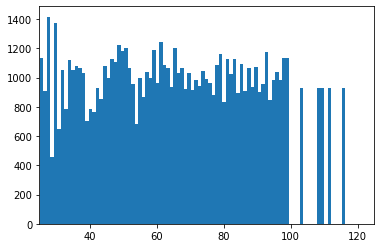

In [93]:
plt.hist(train_y_stratified,100)
plt.xlim([25, 125])
plt.show()

In [94]:
print(len(train_x))
print(len(train_y))
print(len(train_ph))

22827
22827
22827


In [95]:
print(len(train_x_embed_stratified))
print(len(train_y_stratified))
print(len(train_ph_stratified))

77163
77163
77163


In [96]:
train_ph_stratified_list = np.array(train_ph_stratified).reshape([-1, 1])

In [97]:
test_ph_list = np.array(test_ph).reshape([-1, 1])

In [98]:
train_ph_stratified_list.shape

(77163, 1)

In [99]:
test_ph_list.shape

(348, 1)

In [100]:
train_ph_stratified_np_normalized = train_ph_stratified_list / 14

In [101]:
test_ph_np_normalized = test_ph_list / 14

In [102]:
train_x_embed_stratified_with_ph = np.hstack([train_x_embed_stratified_new2, train_ph_stratified_np_normalized])

In [103]:
test_x_embed_with_ph = np.hstack([test_x_embed_new2, test_ph_np_normalized])

In [104]:
train_x_embed_stratified_with_ph.shape

(77163, 1281)

In [105]:
test_x_embed_with_ph.shape

(348, 1281)

In [106]:
train_x_embed_stratified_with_ph[112]

array([ 0.00542757, -0.15962029, -0.00269741, ...,  0.1287173 ,
        0.1576224 ,  0.21428571])

In [107]:
test_x_embed_with_ph[112]

array([-0.00684836, -0.0299269 , -0.02262091, ...,  0.01204001,
        0.04818662,  0.5       ])

In [108]:
X_test = test_x_embed_with_ph

In [109]:
y_test = test_y

In [110]:
X_train = train_x_embed_stratified_with_ph

In [111]:
y_train = train_y_stratified

In [112]:
len(X_train), len(y_train)

(77163, 77163)

In [113]:
len(X_test), len(y_test)

(348, 348)

In [ ]:
# No longer needed as spliting stratified is not a good idea!
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(train_x_embed_stratified_with_ph, train_y_stratified, test_size=0.01, random_state=42, shuffle = True)

## Some memory clean up to help training steps

In [114]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_train', 790766552),
 ('train_x_embed_stratified_with_ph', 790766552),
 ('train_x_embed_stratified_new2', 395074688),
 ('data', 18971748),
 ('df_train', 18971748),
 ('X_test', 3566432),
 ('test_x_embed_with_ph', 3566432),
 ('test_x_embed_new2', 1781888),
 ('train_ph_stratified', 651344),
 ('train_x_embed_stratified', 651344),
 ('train_x_embed_stratified_new', 651344),
 ('train_y_stratified', 651344),
 ('y_train', 651344),
 ('train_ph_stratified_np_normalized', 617432),
 ('sequence_lengths', 253624),
 ('ph', 231904),
 ('df_train_updates', 225013),
 ('data_x_ph', 200312),
 ('data_y', 200312),
 ('train_ph', 200312),
 ('train_repsToStratify', 200312),
 ('train_sequence_lengths', 200312),
 ('train_x', 200312),
 ('train_x_ph', 200312),
 ('train_y', 200312),
 ('all_features_nan', 88010),
 ('drop_indices', 19288),
 ('test_embedding', 10360),
 ('test_ph_np_normalized', 2912),
 ('test_ph', 2888),
 ('test_x', 2888),
 ('test_x_embed', 2888),
 ('test_x_embed_new', 2888),
 ('test_x_ph', 2888),
 

In [115]:
del data
del df_train
del sequence_lengths
del ph
del df_train_updates
del data_x_ph
del data_y

del train_sequence_lengths
del train_repsToStratify
del train_x_ph
del train_y
del train_x
del train_x_embed_stratified_with_ph
del train_x_embed_stratified_new2
del train_x_embed_stratified_new
del train_x_embed_stratified
del train_ph_stratified
del train_ph_stratified_np_normalized
del train_ph
del train_y_stratified

del test_ph_np_normalized
del test_x_embed_with_ph
del test_x_embed_new2
del test_y




# Saving and/or loading all training and test data

### Save

In [116]:
import pickle

In [121]:
with open("X_train_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(X_train, fp)

In [122]:
with open("y_train_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(y_train, fp)

In [123]:
with open("X_test_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(X_test, fp)

In [124]:
with open("y_test_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(y_test, fp)

## Load

In [ ]:
import pickle

In [ ]:
with open("X_train_1p5percentTest.pl", "rb") as fp:
    X_train = pickle.load(fp)

In [ ]:
with open("y_train_1p5percentTest.pl", "rb") as fp:
    y_train = pickle.load(fp)

In [ ]:
with open("X_test_1p5percentTest.pl", "rb") as fp:
    X_test = pickle.load(fp)

In [ ]:
with open("y_test_1p5percentTest.pl", "rb") as fp:
    y_test = pickle.load(fp)

## Things to try first:
- GBM
- Random forrest
- kNN regression

In [125]:
X_train.shape

(77163, 1281)

In [126]:
X_train[0]

array([-0.00101669, -0.06467147,  0.01683933, ...,  0.04582359,
        0.13494533,  0.5       ])

In [163]:
from sklearn.neighbors import KNeighborsRegressor
kNN = KNeighborsRegressor(n_neighbors = 10, weights = 'uniform')
kNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [164]:
y_test_hat = kNN.predict(X_test)

In [165]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_test_hat)

print(MSE ** 0.5)

9.421454758693846


In [166]:
print(y_test_hat[:20])

[49.78 62.63 47.64 49.   39.09 52.08 47.94 54.13 52.72 44.16 35.99 50.67
 57.61 73.5  53.01 45.95 40.86 94.2  66.4  60.83]


In [167]:
print(y_test[:20])

[52.4, 65.9, 45.9, 41.6, 44.1, 49.0, 45.7, 42.0, 52.6, 56.0, 35.7, 39.9, 49.0, 67.4, 52.1, 43.7, 55.6, 88.8, 83.2, 55.5]


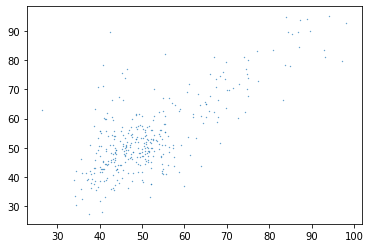

In [168]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_test_hat, s = .1)
plt.show()

In [169]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

corr, _ = pearsonr(y_test, y_test_hat)
print('Pearsons correlation: %.3f' % corr)

r2_score_ = r2_score(y_test, y_test_hat)
print('r2 score: %.3f' % r2_score_)

Pearsons correlation: 0.738
r2 score: 0.424


# Pytorch

In [170]:
import torch
from torch import nn
from torch import optim

#input_dim = 1281
input_dim = 1281 * 2

hidden_dim = 650
hidden_dim2 = 200
hidden_dim3 = 50

output_dim = 1

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.fc1.weight)
        #self.norm1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        nn.init.xavier_uniform_(self.fc2.weight)
        #self.norm2 = nn.BatchNorm1d(hidden_dim2)
        
        #self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim2, output_dim)
        nn.init.xavier_uniform_(self.fc4.weight)
       
    def forward(self, x):
        #x = torch.nn.functional.relu(self.norm1(self.fc1(x)))
        x = torch.nn.functional.relu(self.fc1(x))
        
        x = torch.nn.functional.relu(self.fc2(x))
        
        #x = self.fc3(x)
        x = self.fc4(x)

        return x
       
modelnn = Net(input_dim, hidden_dim, output_dim)
print(modelnn)

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)


In [171]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Available device: " + device)
device = torch.device(device)
modelnn = modelnn.to(device)
learning_rate = 0.0005
loss_fn = nn.HuberLoss(reduction='sum', delta=0.1)
#loss_fn = nn.MarginRankingLoss()

optimizer = torch.optim.Adam(modelnn.parameters(), lr=learning_rate)

loss_fn = loss_fn.to(device)
print(device)

Available device: cuda:0
cuda:0


In [172]:
import random

In [173]:
%autosave 0

Autosave disabled


In [174]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize'))

In [175]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [176]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [177]:
X_train.shape

(77163, 1281)

In [178]:
len(y_train)

77163

In [179]:
y_train_np = np.array(y_train)

In [180]:
y_train_np_normalized = y_train_np / 100

In [181]:
y_train_np_normalized.shape

(77163,)

In [182]:
X_train_torch = torch.from_numpy(X_train.astype(np.float32)).to(device)

In [183]:
y_train_torch = torch.from_numpy(y_train_np_normalized.astype(np.float32)).to(device)

In [184]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [185]:
batch_size = 512

In [186]:
train_data = DataFromTorch(X_train_torch, y_train_torch)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [187]:
X_train_torch.shape

torch.Size([77163, 1281])

In [188]:
y_train_torch.shape

torch.Size([77163])

In [189]:
y_train_torch[:10]

tensor([0.5590, 0.5590, 0.4260, 0.6260, 0.6260, 0.6260, 0.6260, 0.4690, 0.7140,
        0.7140], device='cuda:0')

In [190]:
device

device(type='cuda', index=0)

In [191]:
modelnn.to(device)

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)

In [ ]:
#modelnn.load_state_dict(torch.load('HubertLoss_Layer33_CorrectSplit1p5percent100Epochs'))

In [499]:
print('starting the cell')
num_outer_epochs = 1000
num_epochs = 5
#loss_values = []
modelnn.train()


#SamplesPerTraining = 4
NumberTraings = X_train.shape[0]

print('Starting the outer loop...')
for outer_epoch in range(num_outer_epochs):
    
    Epoch_loss = 0
    
    for index, (X1, y1) in enumerate(train_dataloader):
        #print(X1.shape)
        #print(y1.shape)
        
        random_list = torch.randperm(X_train_torch.shape[0])[:X1.shape[0]]
        #print(random_list.shape)
        #print(random_list)
        X2 = X_train_torch[random_list]
        #print('X2 works and its shape is ' + str(X2.shape))
            
        X = torch.cat((X1, X2), 1)
        #print('X works and its shape is ' + str(X.shape))
            
        y2 = y_train_torch[random_list]
        #print('y2 works and its shape is ' + str(y2.shape))
        
        Batch_loss = 0
        
        for epoch in range(num_epochs):
            
            optimizer.zero_grad()
            pred = modelnn(X)
            y    = (y1-y2).unsqueeze(-1)
            loss = loss_fn(pred, y)
            Batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            
        
        Epoch_loss += Batch_loss
        #print('Batch: ' + str(index) + '\t Loss: ' + str(Batch_loss))
            
    print('Epoch: ' + str(outer_epoch) + '\t Loss: ' + str(Epoch_loss))   

starting the cell
Starting the outer loop...
Epoch: 0	 Loss: 252.28562732040882
Epoch: 1	 Loss: 246.22089828550816
Epoch: 2	 Loss: 249.26024882495403
Epoch: 3	 Loss: 250.5454546660185
Epoch: 4	 Loss: 245.39993806183338
Epoch: 5	 Loss: 244.68105824291706
Epoch: 6	 Loss: 247.3794736713171
Epoch: 7	 Loss: 246.29253143072128
Epoch: 8	 Loss: 241.8688133507967
Epoch: 9	 Loss: 249.90031614899635
Epoch: 10	 Loss: 250.31052188575268
Epoch: 11	 Loss: 252.95549008250237
Epoch: 12	 Loss: 246.2535445690155
Epoch: 13	 Loss: 248.8094701319933
Epoch: 14	 Loss: 246.2594245672226
Epoch: 15	 Loss: 249.24158981442451
Epoch: 16	 Loss: 250.61019058525562
Epoch: 17	 Loss: 246.18129505217075
Epoch: 18	 Loss: 249.92917580902576
Epoch: 19	 Loss: 242.3184544146061
Epoch: 20	 Loss: 249.37860496342182
Epoch: 21	 Loss: 249.9598779976368
Epoch: 22	 Loss: 251.32143178582191
Epoch: 23	 Loss: 244.97917172312737
Epoch: 24	 Loss: 245.76373130083084
Epoch: 25	 Loss: 249.446689337492
Epoch: 26	 Loss: 248.07520107924938
Epo

Epoch: 226	 Loss: 237.98630839586258
Epoch: 227	 Loss: 237.1887460500002
Epoch: 228	 Loss: 239.90883506834507
Epoch: 229	 Loss: 238.39931899309158
Epoch: 230	 Loss: 235.92209577560425
Epoch: 231	 Loss: 236.51767885684967
Epoch: 232	 Loss: 238.20165693759918
Epoch: 233	 Loss: 237.6528071463108
Epoch: 234	 Loss: 236.0249331742525
Epoch: 235	 Loss: 242.50913317501545
Epoch: 236	 Loss: 240.84449718892574
Epoch: 237	 Loss: 234.59702263772488
Epoch: 238	 Loss: 235.21476350724697
Epoch: 239	 Loss: 238.36496655642986
Epoch: 240	 Loss: 241.62636251747608
Epoch: 241	 Loss: 239.30312223732471
Epoch: 242	 Loss: 231.27143961191177
Epoch: 243	 Loss: 236.13340364396572
Epoch: 244	 Loss: 232.38767021894455
Epoch: 245	 Loss: 233.7392907589674
Epoch: 246	 Loss: 233.94793809950352
Epoch: 247	 Loss: 235.4872106909752
Epoch: 248	 Loss: 238.7521907389164
Epoch: 249	 Loss: 238.48575615882874
Epoch: 250	 Loss: 240.09751684963703
Epoch: 251	 Loss: 235.91695500910282
Epoch: 252	 Loss: 230.35621370375156
Epoch: 

Epoch: 450	 Loss: 228.01638227701187
Epoch: 451	 Loss: 223.51201710104942
Epoch: 452	 Loss: 227.72769711911678
Epoch: 453	 Loss: 233.28019228577614
Epoch: 454	 Loss: 231.2319208830595
Epoch: 455	 Loss: 226.96205998957157
Epoch: 456	 Loss: 223.9494065642357
Epoch: 457	 Loss: 227.31508104503155
Epoch: 458	 Loss: 229.87204916775227
Epoch: 459	 Loss: 226.98774275183678
Epoch: 460	 Loss: 227.2932020574808
Epoch: 461	 Loss: 228.2812255769968
Epoch: 462	 Loss: 223.84586253762245
Epoch: 463	 Loss: 226.95922377705574
Epoch: 464	 Loss: 227.64194785058498
Epoch: 465	 Loss: 231.6133921891451
Epoch: 466	 Loss: 229.01229046285152
Epoch: 467	 Loss: 228.35964192450047
Epoch: 468	 Loss: 228.8102453649044
Epoch: 469	 Loss: 224.17082914710045
Epoch: 470	 Loss: 225.57318541407585
Epoch: 471	 Loss: 226.70493346452713
Epoch: 472	 Loss: 228.34391583502293
Epoch: 473	 Loss: 221.85870514810085
Epoch: 474	 Loss: 223.61368626356125
Epoch: 475	 Loss: 225.49483354389668
Epoch: 476	 Loss: 227.72434981167316
Epoch: 

Epoch: 674	 Loss: 220.92370374500751
Epoch: 675	 Loss: 217.47349804639816
Epoch: 676	 Loss: 219.45974925160408
Epoch: 677	 Loss: 213.15410086512566
Epoch: 678	 Loss: 219.67323978245258
Epoch: 679	 Loss: 219.3030352294445
Epoch: 680	 Loss: 223.33431465923786
Epoch: 681	 Loss: 220.36028103530407
Epoch: 682	 Loss: 218.67590467631817
Epoch: 683	 Loss: 221.4508530497551
Epoch: 684	 Loss: 224.82714653015137
Epoch: 685	 Loss: 224.19560952484608
Epoch: 686	 Loss: 218.6149551421404
Epoch: 687	 Loss: 223.89951865375042
Epoch: 688	 Loss: 221.0954825282097
Epoch: 689	 Loss: 223.1090063303709
Epoch: 690	 Loss: 219.77511709928513
Epoch: 691	 Loss: 219.7958993166685
Epoch: 692	 Loss: 217.54352623224258
Epoch: 693	 Loss: 223.51705472171307
Epoch: 694	 Loss: 219.22301317751408
Epoch: 695	 Loss: 217.6329787671566
Epoch: 696	 Loss: 225.51008680462837
Epoch: 697	 Loss: 224.34305679798126
Epoch: 698	 Loss: 219.78535245358944
Epoch: 699	 Loss: 222.07321102917194
Epoch: 700	 Loss: 220.44442936778069
Epoch: 7

Epoch: 898	 Loss: 213.6235561966896
Epoch: 899	 Loss: 213.11519825458527
Epoch: 900	 Loss: 214.00176885724068
Epoch: 901	 Loss: 214.4320347160101
Epoch: 902	 Loss: 213.09735000133514
Epoch: 903	 Loss: 212.66869907081127
Epoch: 904	 Loss: 211.4447088688612
Epoch: 905	 Loss: 210.39236795902252
Epoch: 906	 Loss: 224.33762638270855
Epoch: 907	 Loss: 213.92251580953598
Epoch: 908	 Loss: 215.33144161105156
Epoch: 909	 Loss: 212.86750392615795
Epoch: 910	 Loss: 215.84785367548466
Epoch: 911	 Loss: 214.32790856063366
Epoch: 912	 Loss: 212.4952777326107
Epoch: 913	 Loss: 216.3313386887312
Epoch: 914	 Loss: 213.49837072193623
Epoch: 915	 Loss: 216.25496746599674
Epoch: 916	 Loss: 215.60252030193806
Epoch: 917	 Loss: 209.55398312211037
Epoch: 918	 Loss: 211.4515508711338
Epoch: 919	 Loss: 214.46544168889523
Epoch: 920	 Loss: 212.37866626679897
Epoch: 921	 Loss: 215.08291937410831
Epoch: 922	 Loss: 217.00059142708778
Epoch: 923	 Loss: 209.86226359009743
Epoch: 924	 Loss: 212.75623761117458
Epoch: 

In [500]:
torch.save(modelnn.state_dict(), 'HubertLoss_Layer33_CorrectSplit1p5percent2000Epochs')

In [ ]:
#modelnn.load_state_dict(torch.load('HubertLoss_Layer33_CorrectSplit1p5percent100Epochs'))

In [501]:
X_train_torch.shape

torch.Size([77163, 1281])

In [502]:
y_train_torch.shape

torch.Size([77163])

In [503]:
X_test_torch = torch.from_numpy(X_test.astype(np.float32)).to(device)

In [504]:
y_test[:5]

[52.4, 65.9, 45.9, 41.6, 44.1]

In [505]:
y_test_np = np.array(y_test)
y_test_np_normalized = y_test_np / 100
y_test_torch = torch.from_numpy(y_test_np_normalized.astype(np.float32)).to(device)

In [506]:
X_test_torch.shape, y_test_torch.shape

(torch.Size([348, 1281]), torch.Size([348]))

# Regression

In [507]:
modelnn.eval()

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)

In [ ]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize3'))

## Regression based on making pairs with the entire train data

In [202]:
def getDualRegressionFromEmbedding(embed):
    x_array = []
    y_array = []
    target_array = []
    #print(embed)
    
    preds = []
    preds_rev = []
    ys    = []
    for index, (X1, y1) in enumerate(train_dataloader):
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
        X2 = torch.from_numpy(embed.astype(np.float32)).to(device).unsqueeze(0).repeat(X1.shape[0], 1)
        #X2 = torch.from_numpy(embed.repeat(X1.shape[0]).reshape(X1.shape[0], -1).astype(np.float32)).to(device)
        #print('X2 works and its shape is ' + str(X2.shape))
        #print(X2)
        
            
        X = torch.cat((X1, X2), 1)
        X_rev = torch.cat((X2, X1), 1)
        
        #print('X works and its shape is ' + str(X.shape))
        #print(X)
        with torch.no_grad():
            pred = modelnn(X)
            pred_rev = modelnn(X_rev)
        
        #print('prediction success and shape of output ' + str(pred.shape))
        
        preds.append(pred)
        preds_rev.append(pred_rev)
        ys.append(y1)
        
        
        
    return torch.cat(preds, dim=0).detach().cpu().numpy(), torch.cat(preds_rev, dim=0).detach().cpu().numpy(), torch.cat(ys, dim=0).detach().cpu().numpy()
    

# Regression of difference based on comparing each embedding to test dataset

In [203]:
def getDualRegressionFromTestEmbedding(index, embeddings):
    x_array = []
    y_array = []
    target_array = []
    #print(embed)
    embed = embeddings[index]
    preds = []
    preds_rev = []
    ys    = []
    for index_, x in enumerate(embeddings):
        
        if index == index_:
            continue
            
        x_array.append(np.array(x))
        target_array.append(embed)
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
    x_array = np.array(x_array)
            
    target_array = np.array(target_array)
        
    X_torch = torch.from_numpy(x_array.astype(np.float32))
    target_torch = torch.from_numpy(target_array.astype(np.float32))
        
    input_torch = torch.cat((target_torch, X_torch), 1).to(device)
    input_rev_torch = torch.cat((X_torch, target_torch), 1).to(device)
        
    with torch.no_grad():
        diff_array     = modelnn(input_torch).detach().cpu().numpy()
        diff_rev_array = modelnn(input_rev_torch).detach().cpu().numpy()
    
    estimates_array = 0.5 * diff_array - 0.5 * diff_rev_array 
    
    return estimates_array

# Regression based on comparing two embedding only
Using it to compare with wild

In [290]:
def compareTwo(embed1, embed2):
    x_array = []
    y_array = []
    target_array = []
    #print(embed1)
    #print(embed2)
    preds = []
    preds_rev = []
    ys    = []
            
    x_array.append(embed1)
    target_array.append(embed2)
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
    x_array = np.array(x_array)
    target_array = np.array(target_array)
        
    X_torch = torch.from_numpy(x_array.astype(np.float32))
    target_torch = torch.from_numpy(target_array.astype(np.float32))
        
    input_torch = torch.cat((target_torch, X_torch), 1).to(device)
    input_rev_torch = torch.cat((X_torch, target_torch), 1).to(device)
        
    with torch.no_grad():
        diff_array     = modelnn(input_torch).detach().cpu().numpy()
        diff_rev_array = modelnn(input_rev_torch).detach().cpu().numpy()
    
    estimates_array = 0.5 * diff_array - 0.5 * diff_rev_array 
    
    return estimates_array.squeeze()

### Testing compare two for both train data

In [508]:
index1 = 55 
index2 = 100
embd1 = X_train[index1]
embd2 = X_train[index2]


In [509]:
embd1, y_train_np_normalized[index1] * 100

(array([ 0.04518734, -0.08000548, -0.08818326, ..., -0.04748745,
         0.03928382,  0.5       ]),
 92.6)

In [510]:
embd1, y_train_np_normalized[index2] * 100

(array([ 0.04518734, -0.08000548, -0.08818326, ..., -0.04748745,
         0.03928382,  0.5       ]),
 66.4)

In [511]:
difference = compareTwo(embd1, embd2)

In [512]:
print(difference * 100) #Estimates tm(embed2) - tm(embed1)
print(y_train_np_normalized[index2] * 100 - y_train_np_normalized[index1] * 100)

-25.902849435806274
-26.19999999999999


### Testing compare two for train data and test data

It seems it is a pretty good comparator at least!!!

In [513]:
index1 = 0 
index2 = 100
embd1 = X_test[index1]
embd2 = X_test[index2]

In [514]:
embd1, y_test[index1]

(array([-0.01001186, -0.04838194, -0.01936032, ..., -0.14082199,
         0.06385342,  0.5       ]),
 52.4)

In [515]:
embd2, y_test[index2]

(array([ 0.01858289,  0.04365942, -0.00114911, ..., -0.03735599,
        -0.00369992,  0.5       ]),
 49.4)

In [516]:
difference = compareTwo(embd1, embd2) #Estimates tm(embed2) - tm(embed1)
print(difference * 100)
print(y_test[index2] - y_test[index1])

-9.117325395345688
-3.0


In [204]:
torch.cuda.empty_cache() 

## Quick validation on train and test samples

### Train sample check

In [517]:
index = 55
embd = X_train[index]
X_train[index], y_train_np_normalized[index] * 100

(array([ 0.04518734, -0.08000548, -0.08818326, ..., -0.04748745,
         0.03928382,  0.5       ]),
 92.6)

In [518]:
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embd)

In [519]:
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

In [520]:
res.shape

(77163, 1)

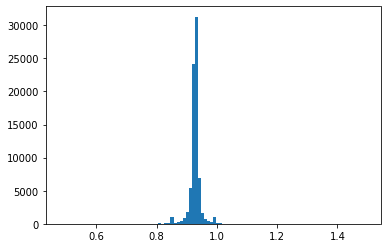

In [521]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [522]:
np.mean(res) * 100, np.median(res) * 100, np.std(res)

(92.66226887702942, 92.741459608078, 0.025042346)

### Test sample check

In [523]:
X_test.shape, len(y_test)

((348, 1281), 348)

In [524]:
y_test[:5]

[52.4, 65.9, 45.9, 41.6, 44.1]

In [525]:
index = 0
embd = X_test[index]
X_test[index], y_test[index] 

(array([-0.01001186, -0.04838194, -0.01936032, ..., -0.14082199,
         0.06385342,  0.5       ]),
 52.4)

In [526]:
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embd)

In [527]:
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

In [528]:
res.shape

(77163, 1)

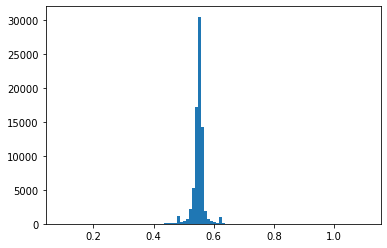

In [529]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [530]:
np.mean(res) * 100, np.median(res) * 100, np.std(res)

(54.948973655700684, 55.08814454078674, 0.025173457)

## Complete Validation of test set

In [531]:
X_test.shape, len(y_test)

((348, 1281), 348)

In [532]:
y_hat_test = []

for index, (test_embed, y) in enumerate(zip(X_test, y_test)):
    #print(test_embed)
    #print(y)
    diff, diff_rev, y_arr = getDualRegressionFromEmbedding(test_embed)
    estimates = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)
    print("{}: Mean {:.2f}, Median {:.2f}, std {:.2f}, truth {:.2f}".format(index, np.mean(estimates), np.median(estimates), np.std(estimates), y))
    y_hat_test.append([np.mean(estimates), np.median(estimates), np.std(estimates)])


0: Mean 0.55, Median 0.55, std 0.03, truth 52.40
1: Mean 0.51, Median 0.51, std 0.03, truth 65.90
2: Mean 0.44, Median 0.44, std 0.03, truth 45.90
3: Mean 0.53, Median 0.53, std 0.03, truth 41.60
4: Mean 0.37, Median 0.37, std 0.03, truth 44.10
5: Mean 0.56, Median 0.56, std 0.03, truth 49.00
6: Mean 0.58, Median 0.58, std 0.03, truth 45.70
7: Mean 0.48, Median 0.48, std 0.03, truth 42.00
8: Mean 0.58, Median 0.58, std 0.03, truth 52.60
9: Mean 0.52, Median 0.52, std 0.03, truth 56.00
10: Mean 0.41, Median 0.41, std 0.03, truth 35.70
11: Mean 0.46, Median 0.46, std 0.03, truth 39.90
12: Mean 0.40, Median 0.40, std 0.03, truth 49.00
13: Mean 0.73, Median 0.73, std 0.03, truth 67.40
14: Mean 0.52, Median 0.52, std 0.03, truth 52.10
15: Mean 0.51, Median 0.51, std 0.03, truth 43.70
16: Mean 0.45, Median 0.45, std 0.03, truth 55.60
17: Mean 0.91, Median 0.91, std 0.03, truth 88.80
18: Mean 0.75, Median 0.75, std 0.02, truth 83.20
19: Mean 0.51, Median 0.51, std 0.03, truth 55.50
20: Mean 0

163: Mean 0.69, Median 0.69, std 0.03, truth 55.30
164: Mean 0.44, Median 0.44, std 0.03, truth 47.70
165: Mean 0.46, Median 0.46, std 0.03, truth 43.90
166: Mean 0.51, Median 0.51, std 0.03, truth 49.90
167: Mean 0.43, Median 0.43, std 0.03, truth 41.90
168: Mean 0.42, Median 0.42, std 0.03, truth 40.50
169: Mean 0.48, Median 0.48, std 0.03, truth 51.40
170: Mean 0.41, Median 0.41, std 0.03, truth 41.50
171: Mean 0.48, Median 0.48, std 0.02, truth 35.50
172: Mean 0.34, Median 0.34, std 0.02, truth 38.80
173: Mean 0.68, Median 0.68, std 0.03, truth 72.60
174: Mean 0.47, Median 0.47, std 0.03, truth 43.70
175: Mean 0.64, Median 0.63, std 0.03, truth 64.30
176: Mean 0.47, Median 0.47, std 0.03, truth 43.10
177: Mean 0.49, Median 0.49, std 0.03, truth 43.10
178: Mean 0.47, Median 0.47, std 0.03, truth 50.00
179: Mean 0.91, Median 0.92, std 0.03, truth 84.00
180: Mean 0.45, Median 0.45, std 0.03, truth 50.90
181: Mean 0.48, Median 0.48, std 0.02, truth 45.60
182: Mean 0.77, Median 0.77, st

324: Mean 0.83, Median 0.83, std 0.03, truth 84.50
325: Mean 0.71, Median 0.71, std 0.03, truth 74.80
326: Mean 0.66, Median 0.66, std 0.03, truth 70.00
327: Mean 0.42, Median 0.42, std 0.02, truth 43.10
328: Mean 0.48, Median 0.48, std 0.03, truth 43.40
329: Mean 0.37, Median 0.37, std 0.03, truth 36.90
330: Mean 0.54, Median 0.54, std 0.03, truth 55.50
331: Mean 0.56, Median 0.56, std 0.03, truth 49.00
332: Mean 0.48, Median 0.48, std 0.02, truth 50.90
333: Mean 0.39, Median 0.39, std 0.03, truth 41.70
334: Mean 0.36, Median 0.36, std 0.03, truth 35.80
335: Mean 0.48, Median 0.48, std 0.03, truth 40.80
336: Mean 0.41, Median 0.41, std 0.03, truth 43.60
337: Mean 0.57, Median 0.57, std 0.03, truth 50.90
338: Mean 0.63, Median 0.64, std 0.03, truth 54.30
339: Mean 0.43, Median 0.43, std 0.02, truth 37.80
340: Mean 0.43, Median 0.43, std 0.03, truth 43.50
341: Mean 0.51, Median 0.51, std 0.03, truth 48.70
342: Mean 0.35, Median 0.36, std 0.02, truth 34.10
343: Mean 0.58, Median 0.58, st

In [533]:
y_hat_test_means = [mean_median_std[0] * 100 for mean_median_std in y_hat_test]
y_hat_test_medians = [mean_median_std[1] * 100 for mean_median_std in y_hat_test]
y_hat_test_stds = [mean_median_std[2] * 100 for mean_median_std in y_hat_test]

In [534]:
y_test[:5]

[52.4, 65.9, 45.9, 41.6, 44.1]

In [535]:
y_hat_test_means[:5]

[54.948973655700684,
 50.82067847251892,
 44.15954351425171,
 52.8891384601593,
 37.03352212905884]

In [536]:
MSE = mean_squared_error(y_test, y_hat_test_medians)

print(MSE ** 0.5)

7.16087369534221


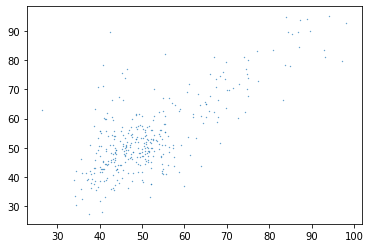

In [537]:
plt.scatter(y_test, y_test_hat, s = .1)
plt.show()

In [538]:
corr, _ = pearsonr(y_test, y_test_hat)
print('Pearsons correlation: %.3f' % corr)

r2_score_ = r2_score(y_test, y_test_hat)
print('r2 score: %.3f' % r2_score_)

Pearsons correlation: 0.738
r2 score: 0.424


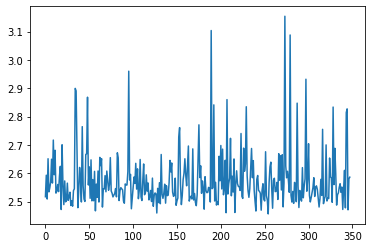

In [539]:
plt.plot(y_hat_test_stds)

# COMPETITION DATA

In [234]:
competition_data = pd.read_csv('./proteindata/test.csv', index_col = False)

In [235]:
competition_data

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [236]:
x_competition = competition_data['protein_sequence'].tolist()

In [237]:
ph_competition = competition_data['pH'].tolist()

In [238]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

# Dont run the cell below if you have the competition embeddings saved!


In [ ]:
x_competition_embed  = []

for i, sequence in enumerate(x_competition):
    print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    x_competition_embed.append(embed)

In [ ]:
import pickle

with open("competition_embeds_pl_new", "wb") as fp:   #Pickling
    #pickle.dump(x_competition_embed, fp)

# Instead load the saved embeddings!


In [239]:
import pickle
with open("competition_embeds_pl_new", "rb") as fp:
    x_competition_embed = pickle.load(fp)

In [240]:
x_competition[:5]

['VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPK

In [241]:
x_competition_embed[:5]

[array([-0.05348419, -0.0577033 , -0.15324247, ..., -0.10081477,
         0.00437558,  0.10947983], dtype=float32),
 array([-0.05385044, -0.05386613, -0.16091336, ..., -0.094506  ,
         0.00279988,  0.1078918 ], dtype=float32),
 array([-0.05591825, -0.05563816, -0.15555942, ..., -0.10034766,
         0.00449493,  0.10842798], dtype=float32),
 array([-0.05603744, -0.04441665, -0.15105218, ..., -0.09418205,
        -0.00062137,  0.10995836], dtype=float32),
 array([-0.05250967, -0.04570286, -0.14952633, ..., -0.08603902,
        -0.00391663,  0.11597865], dtype=float32)]

In [242]:
x_competition_embed_new = [x.reshape([1, -1]) for x in x_competition_embed]

In [243]:
x_competition_embed_new2 = np.vstack(x_competition_embed_new)

In [244]:
train_ph_list = np.array(ph_competition).reshape([-1, 1])

In [245]:
train_ph_np_normalized = train_ph_list / 14

In [246]:
x_competition_embed_with_ph = np.hstack([x_competition_embed_new2, train_ph_np_normalized])

In [247]:
x_competition_embed_with_ph.shape

(2413, 1281)

In [248]:
x_competition_embed_with_ph[:5]

array([[-0.05348419, -0.0577033 , -0.15324247, ...,  0.00437558,
         0.10947983,  0.57142857],
       [-0.05385044, -0.05386613, -0.16091336, ...,  0.00279988,
         0.1078918 ,  0.57142857],
       [-0.05591825, -0.05563816, -0.15555942, ...,  0.00449493,
         0.10842798,  0.57142857],
       [-0.05603744, -0.04441665, -0.15105218, ..., -0.00062137,
         0.10995836,  0.57142857],
       [-0.05250967, -0.04570286, -0.14952633, ..., -0.00391663,
         0.11597865,  0.57142857]])

In [540]:
test_index = 1500
embed = x_competition_embed_with_ph[index]
print(embed)
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

[-0.05652719 -0.05279576 -0.15317661 ... -0.00216204  0.10769878
  0.57142857]


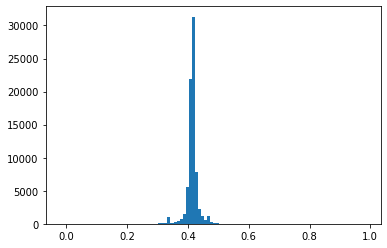

In [541]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [542]:
np.std(res)

0.025675511

In [543]:
np.mean(res) * 100, np.median(res) * 100

(41.38648808002472, 41.43680930137634)

# Regression using the entire train data

In [253]:
y_competition  = []
modelnn.eval()

for i, embed in enumerate(x_competition_embed_with_ph):
    
    diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
    res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)
    print("Working on sequence {}... result is {}".format(i, np.median(res)))
    y_competition.append(np.median(res))

Working on sequence 0... result is 0.40675103664398193
Working on sequence 1... result is 0.41046494245529175
Working on sequence 2... result is 0.4064698815345764
Working on sequence 3... result is 0.4217503070831299
Working on sequence 4... result is 0.4216730296611786
Working on sequence 5... result is 0.41976428031921387
Working on sequence 6... result is 0.4072000980377197
Working on sequence 7... result is 0.41731616854667664
Working on sequence 8... result is 0.42009395360946655
Working on sequence 9... result is 0.42730507254600525
Working on sequence 10... result is 0.42287904024124146
Working on sequence 11... result is 0.4314309358596802
Working on sequence 12... result is 0.42977672815322876
Working on sequence 13... result is 0.42261016368865967
Working on sequence 14... result is 0.41006940603256226
Working on sequence 15... result is 0.40952104330062866
Working on sequence 16... result is 0.42248618602752686
Working on sequence 17... result is 0.4108491539955139
Working 

Working on sequence 148... result is 0.42051398754119873
Working on sequence 149... result is 0.430543452501297
Working on sequence 150... result is 0.4246247410774231
Working on sequence 151... result is 0.4175676703453064
Working on sequence 152... result is 0.414223849773407
Working on sequence 153... result is 0.4259951114654541
Working on sequence 154... result is 0.41596683859825134
Working on sequence 155... result is 0.4194590151309967
Working on sequence 156... result is 0.41669559478759766
Working on sequence 157... result is 0.4108074903488159
Working on sequence 158... result is 0.42842352390289307
Working on sequence 159... result is 0.4177579879760742
Working on sequence 160... result is 0.42159751057624817
Working on sequence 161... result is 0.4170706868171692
Working on sequence 162... result is 0.41896486282348633
Working on sequence 163... result is 0.42707574367523193
Working on sequence 164... result is 0.43120715022087097
Working on sequence 165... result is 0.424

Working on sequence 294... result is 0.4103613495826721
Working on sequence 295... result is 0.41463547945022583
Working on sequence 296... result is 0.4216960072517395
Working on sequence 297... result is 0.4131022095680237
Working on sequence 298... result is 0.4132557511329651
Working on sequence 299... result is 0.4067760705947876
Working on sequence 300... result is 0.4156249165534973
Working on sequence 301... result is 0.41936975717544556
Working on sequence 302... result is 0.41095221042633057
Working on sequence 303... result is 0.41372251510620117
Working on sequence 304... result is 0.4163234233856201
Working on sequence 305... result is 0.41338270902633667
Working on sequence 306... result is 0.41734379529953003
Working on sequence 307... result is 0.4120962619781494
Working on sequence 308... result is 0.41484755277633667
Working on sequence 309... result is 0.4093279242515564
Working on sequence 310... result is 0.42698776721954346
Working on sequence 311... result is 0.4

Working on sequence 440... result is 0.42884647846221924
Working on sequence 441... result is 0.4220304489135742
Working on sequence 442... result is 0.4239444136619568
Working on sequence 443... result is 0.41975873708724976
Working on sequence 444... result is 0.42835110425949097
Working on sequence 445... result is 0.4319884181022644
Working on sequence 446... result is 0.4192948639392853
Working on sequence 447... result is 0.427021861076355
Working on sequence 448... result is 0.41799670457839966
Working on sequence 449... result is 0.41680389642715454
Working on sequence 450... result is 0.42657387256622314
Working on sequence 451... result is 0.41892391443252563
Working on sequence 452... result is 0.4255257844924927
Working on sequence 453... result is 0.4191269874572754
Working on sequence 454... result is 0.4285292625427246
Working on sequence 455... result is 0.42283231019973755
Working on sequence 456... result is 0.42745471000671387
Working on sequence 457... result is 0.4

Working on sequence 586... result is 0.41390639543533325
Working on sequence 587... result is 0.41937750577926636
Working on sequence 588... result is 0.42082899808883667
Working on sequence 589... result is 0.4153200387954712
Working on sequence 590... result is 0.40631425380706787
Working on sequence 591... result is 0.403177946805954
Working on sequence 592... result is 0.41534027457237244
Working on sequence 593... result is 0.42139461636543274
Working on sequence 594... result is 0.40824347734451294
Working on sequence 595... result is 0.42247962951660156
Working on sequence 596... result is 0.42636120319366455
Working on sequence 597... result is 0.43652069568634033
Working on sequence 598... result is 0.437511146068573
Working on sequence 599... result is 0.41888588666915894
Working on sequence 600... result is 0.430106520652771
Working on sequence 601... result is 0.42262548208236694
Working on sequence 602... result is 0.43561261892318726
Working on sequence 603... result is 0

Working on sequence 732... result is 0.4310920536518097
Working on sequence 733... result is 0.41963738203048706
Working on sequence 734... result is 0.4204089343547821
Working on sequence 735... result is 0.421039879322052
Working on sequence 736... result is 0.41457080841064453
Working on sequence 737... result is 0.4191727936267853
Working on sequence 738... result is 0.42364734411239624
Working on sequence 739... result is 0.4201149344444275
Working on sequence 740... result is 0.4271191358566284
Working on sequence 741... result is 0.4163975715637207
Working on sequence 742... result is 0.43510526418685913
Working on sequence 743... result is 0.4198879897594452
Working on sequence 744... result is 0.4302479326725006
Working on sequence 745... result is 0.4331584572792053
Working on sequence 746... result is 0.4086397886276245
Working on sequence 747... result is 0.43339377641677856
Working on sequence 748... result is 0.412462055683136
Working on sequence 749... result is 0.421160

Working on sequence 878... result is 0.4343353509902954
Working on sequence 879... result is 0.42473673820495605
Working on sequence 880... result is 0.4279043674468994
Working on sequence 881... result is 0.42365628480911255
Working on sequence 882... result is 0.4374878406524658
Working on sequence 883... result is 0.422268807888031
Working on sequence 884... result is 0.4218509793281555
Working on sequence 885... result is 0.415813684463501
Working on sequence 886... result is 0.4254917502403259
Working on sequence 887... result is 0.4327337145805359
Working on sequence 888... result is 0.41559934616088867
Working on sequence 889... result is 0.420254111289978
Working on sequence 890... result is 0.4313720464706421
Working on sequence 891... result is 0.41920018196105957
Working on sequence 892... result is 0.4148707389831543
Working on sequence 893... result is 0.42179858684539795
Working on sequence 894... result is 0.4305959939956665
Working on sequence 895... result is 0.4185749

Working on sequence 1024... result is 0.4091968834400177
Working on sequence 1025... result is 0.4152444005012512
Working on sequence 1026... result is 0.415965735912323
Working on sequence 1027... result is 0.4381868243217468
Working on sequence 1028... result is 0.4204480051994324
Working on sequence 1029... result is 0.42548835277557373
Working on sequence 1030... result is 0.41812723875045776
Working on sequence 1031... result is 0.4105514883995056
Working on sequence 1032... result is 0.4309447407722473
Working on sequence 1033... result is 0.4220247268676758
Working on sequence 1034... result is 0.41337066888809204
Working on sequence 1035... result is 0.4098510146141052
Working on sequence 1036... result is 0.40606868267059326
Working on sequence 1037... result is 0.40979087352752686
Working on sequence 1038... result is 0.41851410269737244
Working on sequence 1039... result is 0.41047048568725586
Working on sequence 1040... result is 0.4082353115081787
Working on sequence 1041.

Working on sequence 1167... result is 0.40233659744262695
Working on sequence 1168... result is 0.42263269424438477
Working on sequence 1169... result is 0.4193602204322815
Working on sequence 1170... result is 0.42133259773254395
Working on sequence 1171... result is 0.43514394760131836
Working on sequence 1172... result is 0.42418617010116577
Working on sequence 1173... result is 0.426102876663208
Working on sequence 1174... result is 0.42422688007354736
Working on sequence 1175... result is 0.4232049584388733
Working on sequence 1176... result is 0.39983636140823364
Working on sequence 1177... result is 0.4087143540382385
Working on sequence 1178... result is 0.4177974760532379
Working on sequence 1179... result is 0.41092801094055176
Working on sequence 1180... result is 0.4163729250431061
Working on sequence 1181... result is 0.41287803649902344
Working on sequence 1182... result is 0.41960614919662476
Working on sequence 1183... result is 0.4180840253829956
Working on sequence 11

Working on sequence 1310... result is 0.4214077591896057
Working on sequence 1311... result is 0.42326733469963074
Working on sequence 1312... result is 0.41160184144973755
Working on sequence 1313... result is 0.4151027202606201
Working on sequence 1314... result is 0.4170205593109131
Working on sequence 1315... result is 0.4243021011352539
Working on sequence 1316... result is 0.41759657859802246
Working on sequence 1317... result is 0.41872620582580566
Working on sequence 1318... result is 0.4258717894554138
Working on sequence 1319... result is 0.4199800491333008
Working on sequence 1320... result is 0.41828203201293945
Working on sequence 1321... result is 0.4181021451950073
Working on sequence 1322... result is 0.41789352893829346
Working on sequence 1323... result is 0.4223134517669678
Working on sequence 1324... result is 0.41815871000289917
Working on sequence 1325... result is 0.4321592450141907
Working on sequence 1326... result is 0.4178999066352844
Working on sequence 1327

Working on sequence 1453... result is 0.40988001227378845
Working on sequence 1454... result is 0.41385236382484436
Working on sequence 1455... result is 0.4301977753639221
Working on sequence 1456... result is 0.4232167601585388
Working on sequence 1457... result is 0.41736894845962524
Working on sequence 1458... result is 0.4198060631752014
Working on sequence 1459... result is 0.4280986487865448
Working on sequence 1460... result is 0.4190264344215393
Working on sequence 1461... result is 0.4158303737640381
Working on sequence 1462... result is 0.4211217761039734
Working on sequence 1463... result is 0.4225863814353943
Working on sequence 1464... result is 0.4195283055305481
Working on sequence 1465... result is 0.40589088201522827
Working on sequence 1466... result is 0.4105225205421448
Working on sequence 1467... result is 0.4122641682624817
Working on sequence 1468... result is 0.4157450199127197
Working on sequence 1469... result is 0.4204237461090088
Working on sequence 1470...

Working on sequence 1596... result is 0.4242469072341919
Working on sequence 1597... result is 0.41999390721321106
Working on sequence 1598... result is 0.42846494913101196
Working on sequence 1599... result is 0.4186546206474304
Working on sequence 1600... result is 0.4169400930404663
Working on sequence 1601... result is 0.41910481452941895
Working on sequence 1602... result is 0.41977137327194214
Working on sequence 1603... result is 0.4183974266052246
Working on sequence 1604... result is 0.418124258518219
Working on sequence 1605... result is 0.4155930280685425
Working on sequence 1606... result is 0.4215134382247925
Working on sequence 1607... result is 0.4168289601802826
Working on sequence 1608... result is 0.41680845618247986
Working on sequence 1609... result is 0.41617351770401
Working on sequence 1610... result is 0.419308602809906
Working on sequence 1611... result is 0.4187808036804199
Working on sequence 1612... result is 0.419994056224823
Working on sequence 1613... res

Working on sequence 1740... result is 0.4256535470485687
Working on sequence 1741... result is 0.40483999252319336
Working on sequence 1742... result is 0.41040635108947754
Working on sequence 1743... result is 0.40570423007011414
Working on sequence 1744... result is 0.4212695360183716
Working on sequence 1745... result is 0.41971349716186523
Working on sequence 1746... result is 0.4100171625614166
Working on sequence 1747... result is 0.41693419218063354
Working on sequence 1748... result is 0.40849629044532776
Working on sequence 1749... result is 0.41361331939697266
Working on sequence 1750... result is 0.41799986362457275
Working on sequence 1751... result is 0.4199534058570862
Working on sequence 1752... result is 0.41650331020355225
Working on sequence 1753... result is 0.4146568775177002
Working on sequence 1754... result is 0.4155561029911041
Working on sequence 1755... result is 0.41765666007995605
Working on sequence 1756... result is 0.420271098613739
Working on sequence 17

Working on sequence 1883... result is 0.4247196316719055
Working on sequence 1884... result is 0.4066537618637085
Working on sequence 1885... result is 0.4157940149307251
Working on sequence 1886... result is 0.41574567556381226
Working on sequence 1887... result is 0.4145490825176239
Working on sequence 1888... result is 0.41017723083496094
Working on sequence 1889... result is 0.41065892577171326
Working on sequence 1890... result is 0.40536993741989136
Working on sequence 1891... result is 0.41627341508865356
Working on sequence 1892... result is 0.4184964895248413
Working on sequence 1893... result is 0.41323983669281006
Working on sequence 1894... result is 0.4249376654624939
Working on sequence 1895... result is 0.42873483896255493
Working on sequence 1896... result is 0.421735942363739
Working on sequence 1897... result is 0.41420167684555054
Working on sequence 1898... result is 0.42238855361938477
Working on sequence 1899... result is 0.41411978006362915
Working on sequence 19

Working on sequence 2026... result is 0.4276885688304901
Working on sequence 2027... result is 0.42069151997566223
Working on sequence 2028... result is 0.4218056797981262
Working on sequence 2029... result is 0.42213279008865356
Working on sequence 2030... result is 0.41927051544189453
Working on sequence 2031... result is 0.4159969091415405
Working on sequence 2032... result is 0.4113524556159973
Working on sequence 2033... result is 0.4099162220954895
Working on sequence 2034... result is 0.40942639112472534
Working on sequence 2035... result is 0.4064263105392456
Working on sequence 2036... result is 0.4137727618217468
Working on sequence 2037... result is 0.41710954904556274
Working on sequence 2038... result is 0.41172027587890625
Working on sequence 2039... result is 0.4133199155330658
Working on sequence 2040... result is 0.4138997793197632
Working on sequence 2041... result is 0.42570942640304565
Working on sequence 2042... result is 0.4254501461982727
Working on sequence 2043

Working on sequence 2169... result is 0.4122639298439026
Working on sequence 2170... result is 0.4288884997367859
Working on sequence 2171... result is 0.4192180037498474
Working on sequence 2172... result is 0.41747036576271057
Working on sequence 2173... result is 0.4155387878417969
Working on sequence 2174... result is 0.41709497570991516
Working on sequence 2175... result is 0.3959147036075592
Working on sequence 2176... result is 0.40814220905303955
Working on sequence 2177... result is 0.40466687083244324
Working on sequence 2178... result is 0.41618067026138306
Working on sequence 2179... result is 0.41078272461891174
Working on sequence 2180... result is 0.4077880382537842
Working on sequence 2181... result is 0.40972092747688293
Working on sequence 2182... result is 0.408255934715271
Working on sequence 2183... result is 0.4231979250907898
Working on sequence 2184... result is 0.4339143931865692
Working on sequence 2185... result is 0.4286367893218994
Working on sequence 2186.

Working on sequence 2312... result is 0.41156959533691406
Working on sequence 2313... result is 0.41748887300491333
Working on sequence 2314... result is 0.4150375723838806
Working on sequence 2315... result is 0.42153769731521606
Working on sequence 2316... result is 0.41743457317352295
Working on sequence 2317... result is 0.41801464557647705
Working on sequence 2318... result is 0.41521918773651123
Working on sequence 2319... result is 0.41885268688201904
Working on sequence 2320... result is 0.4288044571876526
Working on sequence 2321... result is 0.4204027056694031
Working on sequence 2322... result is 0.4213729500770569
Working on sequence 2323... result is 0.4201664924621582
Working on sequence 2324... result is 0.41819465160369873
Working on sequence 2325... result is 0.41595911979675293
Working on sequence 2326... result is 0.42022430896759033
Working on sequence 2327... result is 0.4032137393951416
Working on sequence 2328... result is 0.4131810665130615
Working on sequence 2

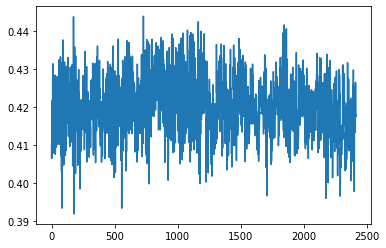

In [343]:
plt.plot(y_competition)

# Regression by comparing each sample with all the other samples in test

In [568]:
y_competition_from_testComps  = []
modelnn.eval()

for i in range(len(x_competition_embed_with_ph)):
    
    estimates = getDualRegressionFromTestEmbedding(i, x_competition_embed_with_ph) * 100
    print("Working on sequence {}... result is: Mean {}, Median {}, std {}".format(i, np.mean(estimates), np.median(estimates), np.std(estimates)))
    y_competition_from_testComps.append([np.mean(estimates), np.median(estimates), np.std(estimates)])

Working on sequence 0... result is: Mean 0.41110336780548096, Median 0.38573816418647766, std 0.9303461909294128
Working on sequence 1... result is: Mean 0.03938276693224907, Median 0.0066027045249938965, std 0.918515682220459
Working on sequence 2... result is: Mean -0.6628848910331726, Median -0.6942227482795715, std 0.927940309047699
Working on sequence 3... result is: Mean 0.1699242889881134, Median 0.13404935598373413, std 0.9222291707992554
Working on sequence 4... result is: Mean -0.9461556673049927, Median -0.9783416986465454, std 0.9327878952026367
Working on sequence 5... result is: Mean -0.5221341848373413, Median -0.5521916151046753, std 0.9326425194740295
Working on sequence 6... result is: Mean -3.040750503540039, Median -3.072174072265625, std 0.9355677962303162
Working on sequence 7... result is: Mean 1.116082787513733, Median 1.0859615802764893, std 0.926507830619812
Working on sequence 8... result is: Mean 0.535012423992157, Median 0.49761906266212463, std 0.929092705

Working on sequence 76... result is: Mean -0.09568427503108978, Median -0.13072043657302856, std 0.9253591895103455
Working on sequence 77... result is: Mean -0.12686097621917725, Median -0.16720443964004517, std 0.9290958642959595
Working on sequence 78... result is: Mean 0.686441957950592, Median 0.654938817024231, std 0.9281476140022278
Working on sequence 79... result is: Mean 0.19829161465168, Median 0.16495957970619202, std 0.9252899289131165
Working on sequence 80... result is: Mean 1.359757661819458, Median 1.323328971862793, std 0.9339216351509094
Working on sequence 81... result is: Mean -1.1214141845703125, Median -1.150672197341919, std 0.9265933036804199
Working on sequence 82... result is: Mean -0.1049032136797905, Median -0.14112219214439392, std 0.9328516125679016
Working on sequence 83... result is: Mean 0.08192623406648636, Median 0.0565163791179657, std 0.9235713481903076
Working on sequence 84... result is: Mean -0.7653488516807556, Median -0.7998153567314148, std 0

Working on sequence 149... result is: Mean 1.0662107467651367, Median 1.0366544723510742, std 0.9325070381164551
Working on sequence 150... result is: Mean 0.4078138768672943, Median 0.3755040466785431, std 0.9338565468788147
Working on sequence 151... result is: Mean 0.40417444705963135, Median 0.36991462111473083, std 0.92974853515625
Working on sequence 152... result is: Mean -0.7982144951820374, Median -0.8299953937530518, std 0.9275109767913818
Working on sequence 153... result is: Mean 0.1477537304162979, Median 0.11277347803115845, std 0.9310017824172974
Working on sequence 154... result is: Mean -0.9030746817588806, Median -0.935855507850647, std 0.9269532561302185
Working on sequence 155... result is: Mean -0.39542385935783386, Median -0.43089985847473145, std 0.9247141480445862
Working on sequence 156... result is: Mean 0.5521795749664307, Median 0.5119621753692627, std 0.9359279870986938
Working on sequence 157... result is: Mean -0.6594406962394714, Median -0.70249289274215

Working on sequence 222... result is: Mean -0.4480363726615906, Median -0.48328712582588196, std 0.9303550720214844
Working on sequence 223... result is: Mean -0.39077600836753845, Median -0.4229307174682617, std 0.9329831004142761
Working on sequence 224... result is: Mean 0.26056554913520813, Median 0.2275034785270691, std 0.9281759262084961
Working on sequence 225... result is: Mean -0.3049156665802002, Median -0.3388121724128723, std 0.9223443865776062
Working on sequence 226... result is: Mean 0.548079788684845, Median 0.5202367901802063, std 0.9272772073745728
Working on sequence 227... result is: Mean 0.8565323352813721, Median 0.8277073502540588, std 0.9263668060302734
Working on sequence 228... result is: Mean 0.43998396396636963, Median 0.408259779214859, std 0.9303374886512756
Working on sequence 229... result is: Mean -0.37147998809814453, Median -0.4007585346698761, std 0.9307577013969421
Working on sequence 230... result is: Mean 0.03896229341626167, Median 0.005873292684

Working on sequence 296... result is: Mean 0.812522828578949, Median 0.7825977802276611, std 0.9401538372039795
Working on sequence 297... result is: Mean -1.5523524284362793, Median -1.587607741355896, std 0.9324977993965149
Working on sequence 298... result is: Mean -0.9864453077316284, Median -1.0207250118255615, std 0.9349780678749084
Working on sequence 299... result is: Mean -1.6117902994155884, Median -1.6457303762435913, std 0.9281007647514343
Working on sequence 300... result is: Mean 0.8197010159492493, Median 0.7880896329879761, std 0.9339222311973572
Working on sequence 301... result is: Mean 0.26436859369277954, Median 0.2298690378665924, std 0.9388063549995422
Working on sequence 302... result is: Mean -0.5615083575248718, Median -0.5928695201873779, std 0.9363219141960144
Working on sequence 303... result is: Mean -0.7452249526977539, Median -0.779534101486206, std 0.9327260255813599
Working on sequence 304... result is: Mean 0.42504680156707764, Median 0.392121076583862

Working on sequence 368... result is: Mean 1.8922792673110962, Median 1.8646098375320435, std 0.925779402256012
Working on sequence 369... result is: Mean 1.6210511922836304, Median 1.5914247035980225, std 0.9304790496826172
Working on sequence 370... result is: Mean 1.0700700283050537, Median 1.04150390625, std 0.923980176448822
Working on sequence 371... result is: Mean 1.3516521453857422, Median 1.3168141841888428, std 0.923434317111969
Working on sequence 372... result is: Mean 0.8196660876274109, Median 0.7863693237304688, std 0.9257801175117493
Working on sequence 373... result is: Mean 0.76844322681427, Median 0.7359042763710022, std 0.9203250408172607
Working on sequence 374... result is: Mean 1.6954127550125122, Median 1.664454460144043, std 0.9231465458869934
Working on sequence 375... result is: Mean 0.7558779716491699, Median 0.7246866822242737, std 0.9253050684928894
Working on sequence 376... result is: Mean 0.4517565071582794, Median 0.4209086298942566, std 0.92254281044

Working on sequence 441... result is: Mean -0.2874840497970581, Median -0.3240033984184265, std 0.9310752153396606
Working on sequence 442... result is: Mean 0.3050258457660675, Median 0.2714477479457855, std 0.9311716556549072
Working on sequence 443... result is: Mean 0.16980387270450592, Median 0.1370742917060852, std 0.9291929006576538
Working on sequence 444... result is: Mean 0.5549349784851074, Median 0.5182914733886719, std 0.927521288394928
Working on sequence 445... result is: Mean 1.4427986145019531, Median 1.407584547996521, std 0.9312918186187744
Working on sequence 446... result is: Mean 0.06139032170176506, Median 0.03146454691886902, std 0.9333645701408386
Working on sequence 447... result is: Mean 0.5095012187957764, Median 0.47371238470077515, std 0.9329074025154114
Working on sequence 448... result is: Mean -0.45215046405792236, Median -0.4901379346847534, std 0.9321646094322205
Working on sequence 449... result is: Mean -0.23769336938858032, Median -0.27337223291397

Working on sequence 518... result is: Mean -0.2201843559741974, Median -0.2511650323867798, std 0.9310755133628845
Working on sequence 519... result is: Mean 0.43972060084342957, Median 0.4096508026123047, std 0.9263318777084351
Working on sequence 520... result is: Mean -0.11128146201372147, Median -0.14627426862716675, std 0.9232714176177979
Working on sequence 521... result is: Mean 0.9112012386322021, Median 0.8757859468460083, std 0.9170481562614441
Working on sequence 522... result is: Mean 0.09590594470500946, Median 0.06355941295623779, std 0.9199036955833435
Working on sequence 523... result is: Mean 0.7705748081207275, Median 0.7425397634506226, std 0.9250094890594482
Working on sequence 524... result is: Mean 0.23254045844078064, Median 0.19942373037338257, std 0.9106152653694153
Working on sequence 525... result is: Mean 1.4298125505447388, Median 1.3913094997406006, std 0.9246265888214111
Working on sequence 526... result is: Mean 2.8882675170898438, Median 2.8556599617004

Working on sequence 590... result is: Mean -0.6883202791213989, Median -0.721434473991394, std 0.9157400727272034
Working on sequence 591... result is: Mean -4.244527339935303, Median -4.267635822296143, std 0.913170337677002
Working on sequence 592... result is: Mean -0.928460955619812, Median -0.954921543598175, std 0.9316470623016357
Working on sequence 593... result is: Mean -0.7447094917297363, Median -0.7737040519714355, std 0.9327353835105896
Working on sequence 594... result is: Mean -0.34999823570251465, Median -0.38165152072906494, std 0.9275417923927307
Working on sequence 595... result is: Mean -1.7029047012329102, Median -1.735567331314087, std 0.9295061230659485
Working on sequence 596... result is: Mean -0.9363164305686951, Median -0.9673565626144409, std 0.933944821357727
Working on sequence 597... result is: Mean 0.14087913930416107, Median 0.09654834866523743, std 0.9402368068695068
Working on sequence 598... result is: Mean -0.9140989184379578, Median -0.950310349464

Working on sequence 663... result is: Mean 0.5686697363853455, Median 0.5330577492713928, std 0.9326922297477722
Working on sequence 664... result is: Mean -2.151399612426758, Median -2.1809659004211426, std 0.9114410877227783
Working on sequence 665... result is: Mean -0.13860388100147247, Median -0.17740949988365173, std 0.9329197406768799
Working on sequence 666... result is: Mean -0.5179567933082581, Median -0.5491353273391724, std 0.9238898754119873
Working on sequence 667... result is: Mean 0.36530372500419617, Median 0.33234357833862305, std 0.9211016297340393
Working on sequence 668... result is: Mean -0.06730560958385468, Median -0.10017827153205872, std 0.9264245629310608
Working on sequence 669... result is: Mean -0.005017661955207586, Median -0.039255619049072266, std 0.9302027225494385
Working on sequence 670... result is: Mean 0.11189825087785721, Median 0.07752105593681335, std 0.925402820110321
Working on sequence 671... result is: Mean -0.1863984614610672, Median -0.21

Working on sequence 738... result is: Mean 0.10579589009284973, Median 0.06996318697929382, std 0.9364864826202393
Working on sequence 739... result is: Mean -0.18307971954345703, Median -0.21818876266479492, std 0.9344716668128967
Working on sequence 740... result is: Mean 0.8064934015274048, Median 0.7704704999923706, std 0.9310309886932373
Working on sequence 741... result is: Mean -0.03715803474187851, Median -0.0710517168045044, std 0.9302155375480652
Working on sequence 742... result is: Mean -0.25979137420654297, Median -0.2973489463329315, std 0.9220364689826965
Working on sequence 743... result is: Mean 0.21872170269489288, Median 0.18741488456726074, std 0.9290821552276611
Working on sequence 744... result is: Mean 1.5276418924331665, Median 1.498955488204956, std 0.9279894232749939
Working on sequence 745... result is: Mean 0.12833458185195923, Median 0.08812397718429565, std 0.9122891426086426
Working on sequence 746... result is: Mean -0.1795726865530014, Median -0.2139680

Working on sequence 812... result is: Mean 0.2632351219654083, Median 0.22934675216674805, std 0.9342184066772461
Working on sequence 813... result is: Mean 0.01705583743751049, Median -0.014505535364151001, std 0.9245158433914185
Working on sequence 814... result is: Mean 0.620918333530426, Median 0.5866199731826782, std 0.9257674217224121
Working on sequence 815... result is: Mean 0.15597127377986908, Median 0.12299269437789917, std 0.9284804463386536
Working on sequence 816... result is: Mean -0.41266748309135437, Median -0.44863075017929077, std 0.9144191145896912
Working on sequence 817... result is: Mean 0.19215120375156403, Median 0.15907585620880127, std 0.9327684044837952
Working on sequence 818... result is: Mean 0.65046226978302, Median 0.6201773881912231, std 0.9336851835250854
Working on sequence 819... result is: Mean 1.2063783407211304, Median 1.1790707111358643, std 0.9305958151817322
Working on sequence 820... result is: Mean 1.4941469430923462, Median 1.46805119514465

Working on sequence 887... result is: Mean 2.495866298675537, Median 2.4624557495117188, std 0.9243753552436829
Working on sequence 888... result is: Mean -0.391782283782959, Median -0.4273742437362671, std 0.9277696013450623
Working on sequence 889... result is: Mean 1.096631407737732, Median 1.0674387216567993, std 0.9213873744010925
Working on sequence 890... result is: Mean 2.172483205795288, Median 2.139802932739258, std 0.9270864725112915
Working on sequence 891... result is: Mean 0.3047914505004883, Median 0.2718307077884674, std 0.9277516603469849
Working on sequence 892... result is: Mean -0.8319122195243835, Median -0.8621596097946167, std 0.9289994835853577
Working on sequence 893... result is: Mean 0.5215907096862793, Median 0.4875652492046356, std 0.9203596711158752
Working on sequence 894... result is: Mean 1.3669363260269165, Median 1.3348743915557861, std 0.9315418004989624
Working on sequence 895... result is: Mean -0.4144452214241028, Median -0.43870583176612854, std 

Working on sequence 964... result is: Mean -0.6521651744842529, Median -0.6821655035018921, std 0.9205805659294128
Working on sequence 965... result is: Mean 0.20732328295707703, Median 0.17499923706054688, std 0.9251057505607605
Working on sequence 966... result is: Mean 0.4076538383960724, Median 0.3789052367210388, std 0.9229875802993774
Working on sequence 967... result is: Mean -0.20899459719657898, Median -0.23877322673797607, std 0.9257526993751526
Working on sequence 968... result is: Mean 0.10679768025875092, Median 0.06865188479423523, std 0.9315937161445618
Working on sequence 969... result is: Mean 0.5152992606163025, Median 0.48074349761009216, std 0.9136350154876709
Working on sequence 970... result is: Mean 1.2936508655548096, Median 1.2585818767547607, std 0.93193519115448
Working on sequence 971... result is: Mean -0.3882295489311218, Median -0.4247412085533142, std 0.9288933277130127
Working on sequence 972... result is: Mean 0.5851060152053833, Median 0.5493171215057

Working on sequence 1038... result is: Mean 0.6310821771621704, Median 0.5984700918197632, std 0.9265679121017456
Working on sequence 1039... result is: Mean -0.6083498597145081, Median -0.6446666717529297, std 0.9251307845115662
Working on sequence 1040... result is: Mean -1.529415488243103, Median -1.560094952583313, std 0.9228399395942688
Working on sequence 1041... result is: Mean 0.1814318150281906, Median 0.14923885464668274, std 0.9285083413124084
Working on sequence 1042... result is: Mean 0.6273233890533447, Median 0.588803768157959, std 0.9220856428146362
Working on sequence 1043... result is: Mean 1.1014527082443237, Median 1.0715148448944092, std 0.9293347597122192
Working on sequence 1044... result is: Mean 1.5241976976394653, Median 1.494563341140747, std 0.9281105995178223
Working on sequence 1045... result is: Mean -0.3087307810783386, Median -0.34261569380760193, std 0.9246484637260437
Working on sequence 1046... result is: Mean -0.3664668798446655, Median -0.395239144

Working on sequence 1113... result is: Mean 0.5417348742485046, Median 0.5117312073707581, std 0.9305210113525391
Working on sequence 1114... result is: Mean 1.2465213537216187, Median 1.2122466564178467, std 0.9282833933830261
Working on sequence 1115... result is: Mean -0.10336418449878693, Median -0.1344718039035797, std 0.9309387803077698
Working on sequence 1116... result is: Mean -0.4220965802669525, Median -0.4610083997249603, std 0.9285679459571838
Working on sequence 1117... result is: Mean 0.21427854895591736, Median 0.1849941909313202, std 0.9127424955368042
Working on sequence 1118... result is: Mean 0.7718731760978699, Median 0.743161141872406, std 0.91434246301651
Working on sequence 1119... result is: Mean 1.3919495344161987, Median 1.3536423444747925, std 0.9300193786621094
Working on sequence 1120... result is: Mean 0.9576578140258789, Median 0.9323745965957642, std 0.9226952195167542
Working on sequence 1121... result is: Mean 2.0546047687530518, Median 2.028336524963

Working on sequence 1187... result is: Mean 0.31876620650291443, Median 0.2878338098526001, std 0.931896448135376
Working on sequence 1188... result is: Mean 0.32393139600753784, Median 0.292302668094635, std 0.9354891180992126
Working on sequence 1189... result is: Mean 0.8166911602020264, Median 0.784282386302948, std 0.9378238320350647
Working on sequence 1190... result is: Mean -0.18866893649101257, Median -0.22535920143127441, std 0.9315600395202637
Working on sequence 1191... result is: Mean -0.4511713683605194, Median -0.4749298095703125, std 0.9355297088623047
Working on sequence 1192... result is: Mean 0.19736997783184052, Median 0.16581416130065918, std 0.9210802316665649
Working on sequence 1193... result is: Mean 0.5939486026763916, Median 0.5617976188659668, std 0.9286699295043945
Working on sequence 1194... result is: Mean -0.08884138613939285, Median -0.12052655220031738, std 0.9254951477050781
Working on sequence 1195... result is: Mean 0.44183364510536194, Median 0.412

Working on sequence 1261... result is: Mean -1.1226359605789185, Median -1.1542870998382568, std 0.9240437150001526
Working on sequence 1262... result is: Mean -0.9702049493789673, Median -1.0027661323547363, std 0.92457115650177
Working on sequence 1263... result is: Mean -0.3932957053184509, Median -0.4274427890777588, std 0.9221905469894409
Working on sequence 1264... result is: Mean -1.6237380504608154, Median -1.6587965488433838, std 0.9202760457992554
Working on sequence 1265... result is: Mean -0.8464983701705933, Median -0.8754834532737732, std 0.9226483106613159
Working on sequence 1266... result is: Mean -1.0400779247283936, Median -1.0703787803649902, std 0.9238361716270447
Working on sequence 1267... result is: Mean -1.2778068780899048, Median -1.3083562850952148, std 0.9240701794624329
Working on sequence 1268... result is: Mean -1.382442593574524, Median -1.4120354652404785, std 0.925511360168457
Working on sequence 1269... result is: Mean -1.3076081275939941, Median -1.3

Working on sequence 1335... result is: Mean 1.0863088369369507, Median 1.0505110025405884, std 0.9319829940795898
Working on sequence 1336... result is: Mean -0.14945165812969208, Median -0.18120333552360535, std 0.9281691908836365
Working on sequence 1337... result is: Mean 0.6455485820770264, Median 0.610622763633728, std 0.9335584044456482
Working on sequence 1338... result is: Mean 0.8349819183349609, Median 0.799289345741272, std 0.9297172427177429
Working on sequence 1339... result is: Mean 0.4625687599182129, Median 0.42766034603118896, std 0.9319777488708496
Working on sequence 1340... result is: Mean 0.3209381401538849, Median 0.28622448444366455, std 0.9323885440826416
Working on sequence 1341... result is: Mean -1.2095330953598022, Median -1.245760202407837, std 0.9270955920219421
Working on sequence 1342... result is: Mean 0.7726936340332031, Median 0.7385052442550659, std 0.9309853911399841
Working on sequence 1343... result is: Mean 0.8532069325447083, Median 0.8203990459

Working on sequence 1407... result is: Mean 0.1635889708995819, Median 0.1325644552707672, std 0.9288244247436523
Working on sequence 1408... result is: Mean 0.08577820658683777, Median 0.05470886826515198, std 0.9287646412849426
Working on sequence 1409... result is: Mean -0.6195015907287598, Median -0.6508931517601013, std 0.9351658821105957
Working on sequence 1410... result is: Mean 0.46570542454719543, Median 0.4322044551372528, std 0.9314109683036804
Working on sequence 1411... result is: Mean -0.07157339155673981, Median -0.1024484634399414, std 0.9332353472709656
Working on sequence 1412... result is: Mean 0.07104285806417465, Median 0.03615245223045349, std 0.9296715259552002
Working on sequence 1413... result is: Mean 0.7629258036613464, Median 0.729641318321228, std 0.9291722774505615
Working on sequence 1414... result is: Mean 0.14161325991153717, Median 0.10784566402435303, std 0.9331700205802917
Working on sequence 1415... result is: Mean 0.6952726244926453, Median 0.6675

Working on sequence 1480... result is: Mean 0.1710725575685501, Median 0.13485252857208252, std 0.9330905079841614
Working on sequence 1481... result is: Mean 0.19639058411121368, Median 0.16122236847877502, std 0.9309284090995789
Working on sequence 1482... result is: Mean -0.658294141292572, Median -0.6942875385284424, std 0.9296146035194397
Working on sequence 1483... result is: Mean -0.7133916616439819, Median -0.7483236789703369, std 0.9281474351882935
Working on sequence 1484... result is: Mean 0.5275171399116516, Median 0.4943251609802246, std 0.9261364340782166
Working on sequence 1485... result is: Mean 0.5324249267578125, Median 0.49738138914108276, std 0.9294519424438477
Working on sequence 1486... result is: Mean 0.2639223039150238, Median 0.22984221577644348, std 0.9313927888870239
Working on sequence 1487... result is: Mean 1.0170872211456299, Median 0.9820781946182251, std 0.9279822111129761
Working on sequence 1488... result is: Mean 1.1794383525848389, Median 1.1435396

Working on sequence 1556... result is: Mean 0.8233869671821594, Median 0.7950156927108765, std 0.9188018441200256
Working on sequence 1557... result is: Mean 1.8992877006530762, Median 1.862245798110962, std 0.9179994463920593
Working on sequence 1558... result is: Mean 0.3911108374595642, Median 0.3607064485549927, std 0.9214649796485901
Working on sequence 1559... result is: Mean 0.6299076080322266, Median 0.5954816937446594, std 0.9221800565719604
Working on sequence 1560... result is: Mean 0.8473619818687439, Median 0.8177406787872314, std 0.9210760593414307
Working on sequence 1561... result is: Mean 0.303209513425827, Median 0.27277469635009766, std 0.9322022199630737
Working on sequence 1562... result is: Mean 0.549826979637146, Median 0.5208507180213928, std 0.9282228946685791
Working on sequence 1563... result is: Mean 0.5974369645118713, Median 0.5669087171554565, std 0.9255072474479675
Working on sequence 1564... result is: Mean -0.3554772138595581, Median -0.388272851705551

Working on sequence 1629... result is: Mean -3.4406373500823975, Median -3.470669746398926, std 0.9099459052085876
Working on sequence 1630... result is: Mean -2.5897746086120605, Median -2.614478826522827, std 0.9201593399047852
Working on sequence 1631... result is: Mean -0.6639359593391418, Median -0.6921857595443726, std 0.9210622310638428
Working on sequence 1632... result is: Mean -1.6418120861053467, Median -1.6687124967575073, std 0.9212226867675781
Working on sequence 1633... result is: Mean -1.3900941610336304, Median -1.4233119487762451, std 0.9261403679847717
Working on sequence 1634... result is: Mean -1.7716639041900635, Median -1.8010109663009644, std 0.9232706427574158
Working on sequence 1635... result is: Mean -2.2735908031463623, Median -2.307075262069702, std 0.9263896346092224
Working on sequence 1636... result is: Mean -2.041698694229126, Median -2.0733370780944824, std 0.9246734976768494
Working on sequence 1637... result is: Mean -1.6657031774520874, Median -1.6

Working on sequence 1700... result is: Mean 0.5053074359893799, Median 0.47294124960899353, std 0.9249210953712463
Working on sequence 1701... result is: Mean 0.9241625666618347, Median 0.8906006813049316, std 0.9283433556556702
Working on sequence 1702... result is: Mean 0.2916509211063385, Median 0.25768429040908813, std 0.9283266067504883
Working on sequence 1703... result is: Mean 0.22845245897769928, Median 0.198277086019516, std 0.9199314117431641
Working on sequence 1704... result is: Mean 0.79716557264328, Median 0.7688760757446289, std 0.9198954701423645
Working on sequence 1705... result is: Mean 1.319522738456726, Median 1.286982774734497, std 0.9222034215927124
Working on sequence 1706... result is: Mean 1.1438146829605103, Median 1.111131191253662, std 0.9268817901611328
Working on sequence 1707... result is: Mean -3.5059914588928223, Median -3.533008575439453, std 0.9128727316856384
Working on sequence 1708... result is: Mean 1.2713463306427002, Median 1.2407972812652588,

Working on sequence 1775... result is: Mean 0.9439372420310974, Median 0.910178542137146, std 0.9133217334747314
Working on sequence 1776... result is: Mean 0.2768980860710144, Median 0.2452068030834198, std 0.9244006872177124
Working on sequence 1777... result is: Mean 0.874680757522583, Median 0.8389860391616821, std 0.9130496978759766
Working on sequence 1778... result is: Mean 0.318814218044281, Median 0.286141037940979, std 0.9177175760269165
Working on sequence 1779... result is: Mean 0.09626788645982742, Median 0.0622577965259552, std 0.919959306716919
Working on sequence 1780... result is: Mean 0.7037630677223206, Median 0.6700493097305298, std 0.9209710955619812
Working on sequence 1781... result is: Mean 0.781013548374176, Median 0.7479749917984009, std 0.923184871673584
Working on sequence 1782... result is: Mean 0.6270998120307922, Median 0.5934432148933411, std 0.9205522537231445
Working on sequence 1783... result is: Mean 0.8177733421325684, Median 0.7834911346435547, std

Working on sequence 1850... result is: Mean 0.8155609965324402, Median 0.7795095443725586, std 0.8944300413131714
Working on sequence 1851... result is: Mean 0.9288663864135742, Median 0.8890860080718994, std 0.9073379039764404
Working on sequence 1852... result is: Mean -1.7372771501541138, Median -1.7621972560882568, std 0.9235895872116089
Working on sequence 1853... result is: Mean 0.9981972575187683, Median 0.962295413017273, std 0.9047277569770813
Working on sequence 1854... result is: Mean -0.05660415440797806, Median -0.09568855166435242, std 0.9015496969223022
Working on sequence 1855... result is: Mean 0.7230901718139648, Median 0.6816811561584473, std 0.8969057202339172
Working on sequence 1856... result is: Mean 0.08817034214735031, Median 0.0467449426651001, std 0.89817875623703
Working on sequence 1857... result is: Mean -0.5757426023483276, Median -0.6131939888000488, std 0.906676173210144
Working on sequence 1858... result is: Mean -0.44558244943618774, Median -0.4781827

Working on sequence 1924... result is: Mean -0.17853660881519318, Median -0.21504759788513184, std 0.930130124092102
Working on sequence 1925... result is: Mean -0.1536162793636322, Median -0.19052699208259583, std 0.9309002161026001
Working on sequence 1926... result is: Mean 0.31352412700653076, Median 0.28514042496681213, std 0.9229205846786499
Working on sequence 1927... result is: Mean 0.8633666038513184, Median 0.8307397365570068, std 0.9260188341140747
Working on sequence 1928... result is: Mean 0.21639609336853027, Median 0.18534958362579346, std 0.9257560968399048
Working on sequence 1929... result is: Mean -0.08035247772932053, Median -0.11389479041099548, std 0.9245890378952026
Working on sequence 1930... result is: Mean 0.019119028002023697, Median -0.01394227147102356, std 0.9241189360618591
Working on sequence 1931... result is: Mean -1.1811161041259766, Median -1.2157506942749023, std 0.9229116439819336
Working on sequence 1932... result is: Mean 0.08148711174726486, Med

Working on sequence 1995... result is: Mean -0.34315162897109985, Median -0.3774017095565796, std 0.9313267469406128
Working on sequence 1996... result is: Mean 0.07053503394126892, Median 0.036612898111343384, std 0.929717481136322
Working on sequence 1997... result is: Mean 0.30425673723220825, Median 0.27358755469322205, std 0.933605432510376
Working on sequence 1998... result is: Mean -0.013290930539369583, Median -0.046119093894958496, std 0.9334389567375183
Working on sequence 1999... result is: Mean -0.03872399032115936, Median -0.07133856415748596, std 0.9320324063301086
Working on sequence 2000... result is: Mean -0.0926518365740776, Median -0.12316927313804626, std 0.9320501089096069
Working on sequence 2001... result is: Mean 0.3116450011730194, Median 0.270303338766098, std 0.931145191192627
Working on sequence 2002... result is: Mean 1.017467975616455, Median 0.9840183258056641, std 0.9323089122772217
Working on sequence 2003... result is: Mean 0.7168228626251221, Median 0

Working on sequence 2066... result is: Mean -1.5985596179962158, Median -1.6283012628555298, std 0.9264084696769714
Working on sequence 2067... result is: Mean -1.2570092678070068, Median -1.2872159481048584, std 0.922531247138977
Working on sequence 2068... result is: Mean -0.812462329864502, Median -0.8468962907791138, std 0.9259200096130371
Working on sequence 2069... result is: Mean 0.715308427810669, Median 0.6784267425537109, std 0.927331805229187
Working on sequence 2070... result is: Mean 0.9317580461502075, Median 0.8961372375488281, std 0.9160721898078918
Working on sequence 2071... result is: Mean 0.3191687762737274, Median 0.2884216606616974, std 0.9280274510383606
Working on sequence 2072... result is: Mean -0.5815093517303467, Median -0.6154276132583618, std 0.9303045868873596
Working on sequence 2073... result is: Mean 1.0787371397018433, Median 1.0447978973388672, std 0.9312244653701782
Working on sequence 2074... result is: Mean -0.2621101438999176, Median -0.294107198

Working on sequence 2138... result is: Mean -0.17110949754714966, Median -0.2077437937259674, std 0.9362450242042542
Working on sequence 2139... result is: Mean -0.17349645495414734, Median -0.20253658294677734, std 0.9351257085800171
Working on sequence 2140... result is: Mean -1.283078670501709, Median -1.321566104888916, std 0.9319251775741577
Working on sequence 2141... result is: Mean -1.2110258340835571, Median -1.2456700801849365, std 0.9227511286735535
Working on sequence 2142... result is: Mean -0.4185470640659332, Median -0.4490859806537628, std 0.9204559326171875
Working on sequence 2143... result is: Mean -0.21668198704719543, Median -0.24699270725250244, std 0.923292338848114
Working on sequence 2144... result is: Mean -0.7693072557449341, Median -0.8002281188964844, std 0.9239983558654785
Working on sequence 2145... result is: Mean -0.5891233682632446, Median -0.6192363500595093, std 0.9250403642654419
Working on sequence 2146... result is: Mean -1.542820930480957, Median

Working on sequence 2213... result is: Mean 0.1503698080778122, Median 0.11515840888023376, std 0.9337362051010132
Working on sequence 2214... result is: Mean 0.39611750841140747, Median 0.35941898822784424, std 0.9315172433853149
Working on sequence 2215... result is: Mean -0.011410332284867764, Median -0.04825294017791748, std 0.9258188605308533
Working on sequence 2216... result is: Mean 0.575538158416748, Median 0.5380257964134216, std 0.9339674711227417
Working on sequence 2217... result is: Mean 0.5174750685691833, Median 0.4801355302333832, std 0.9296225905418396
Working on sequence 2218... result is: Mean 0.8194519877433777, Median 0.7891095876693726, std 0.9236449003219604
Working on sequence 2219... result is: Mean 1.0877647399902344, Median 1.059625267982483, std 0.9316699504852295
Working on sequence 2220... result is: Mean 0.06374488025903702, Median 0.03760308027267456, std 0.9333406090736389
Working on sequence 2221... result is: Mean 0.6548577547073364, Median 0.6185196

Working on sequence 2288... result is: Mean -2.476471424102783, Median -2.511259078979492, std 0.9278196692466736
Working on sequence 2289... result is: Mean -0.7133837938308716, Median -0.7500976324081421, std 0.92855304479599
Working on sequence 2290... result is: Mean -1.074263095855713, Median -1.1095225811004639, std 0.9276871681213379
Working on sequence 2291... result is: Mean -1.7669050693511963, Median -1.803205966949463, std 0.9316259622573853
Working on sequence 2292... result is: Mean -2.200924873352051, Median -2.2367820739746094, std 0.9232318997383118
Working on sequence 2293... result is: Mean -1.2735826969146729, Median -1.3074471950531006, std 0.9288766384124756
Working on sequence 2294... result is: Mean -1.183868169784546, Median -1.2188925743103027, std 0.9267908930778503
Working on sequence 2295... result is: Mean -0.583436131477356, Median -0.6154007911682129, std 0.9341126680374146
Working on sequence 2296... result is: Mean -0.18302376568317413, Median -0.21461

Working on sequence 2359... result is: Mean -2.2270195484161377, Median -2.2583746910095215, std 0.9275771379470825
Working on sequence 2360... result is: Mean -1.6366859674453735, Median -1.6679160594940186, std 0.9250101447105408
Working on sequence 2361... result is: Mean -0.5122595429420471, Median -0.548572838306427, std 0.9322973489761353
Working on sequence 2362... result is: Mean -0.4748101830482483, Median -0.5101785063743591, std 0.9248628616333008
Working on sequence 2363... result is: Mean -0.8679834604263306, Median -0.9039834141731262, std 0.9271916747093201
Working on sequence 2364... result is: Mean -1.2783814668655396, Median -1.3123482465744019, std 0.9256293177604675
Working on sequence 2365... result is: Mean -2.6091740131378174, Median -2.6373519897460938, std 0.9222506284713745
Working on sequence 2366... result is: Mean -1.5402228832244873, Median -1.5763282775878906, std 0.9199466705322266
Working on sequence 2367... result is: Mean -0.19526691734790802, Median 

In [569]:
y_competition_from_testComps[:5]

[[0.41110337, 0.38573816, 0.9303462],
 [0.039382767, 0.0066027045, 0.9185157],
 [-0.6628849, -0.69422275, 0.9279403],
 [0.16992429, 0.13404936, 0.9222292],
 [-0.94615567, -0.9783417, 0.9327879]]

In [570]:
y_competition_means = [mean_median_std[0] for mean_median_std in y_competition_from_testComps]

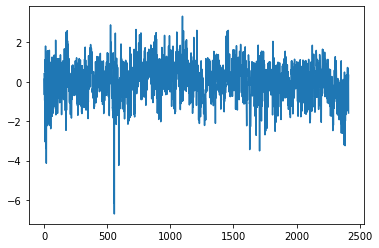

In [571]:
plt.plot(y_competition_means)

In [572]:
y_competition_medians = [mean_median_std[1] for mean_median_std in y_competition_from_testComps]

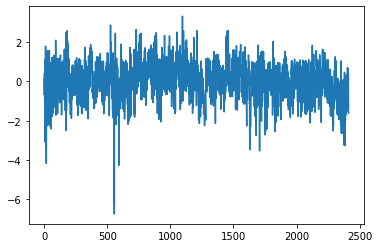

In [573]:
plt.plot(y_competition_medians)

In [ ]:
plt.scatter(y_competition_medians, y_competition_means)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [ ]:
y_competition_stds = [mean_median_std[2] for mean_median_std in y_competition_from_testComps]

In [ ]:
plt.plot(y_competition_stds)

# Regression by comparing each sample with the wild type!

In [360]:
# Exaple for testing the function to use as guide
difference = compareTwo(embd1, embd2) #Estimates tm(embed2) - tm(embed1)
print(difference * 100)
print(y_test[index2] - y_test[index1])

-0.6982564926147461
-3.0


In [361]:
base

'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

In [381]:
wildembed = ESMembedding(base)

In [382]:
wildembed = np.append(wildembed, 8 / 14) #Just adding the pH

In [383]:
wildembed

array([-5.43640628e-02, -5.18425293e-02, -1.54384911e-01, ...,
       -5.21751586e-04,  1.08784892e-01,  5.71428571e-01])

In [392]:
y_competition  = []
modelnn.eval()

for i, embed in enumerate(x_competition_embed_with_ph):
    
    difference = compareTwo(wildembed, embed)  * 100
    print("Index {}... difference is {}".format(i, difference))
    y_competition.append(difference)

Index 0... difference is -0.5687810480594635
Index 1... difference is -0.8532553911209106
Index 2... difference is -1.2651331722736359
Index 3... difference is 2.3196592926979065
Index 4... difference is 0.23256763815879822
Index 5... difference is 0.11113807559013367
Index 6... difference is -0.6583988666534424
Index 7... difference is 0.31424611806869507
Index 8... difference is 0.13824626803398132
Index 9... difference is 2.364654093980789
Index 10... difference is 0.45058801770210266
Index 11... difference is 1.585763692855835
Index 12... difference is 1.1901408433914185
Index 13... difference is 0.4412524402141571
Index 14... difference is -0.6684504449367523
Index 15... difference is -0.5291648209095001
Index 16... difference is 0.40030255913734436
Index 17... difference is -0.4622727632522583
Index 18... difference is -0.20535290241241455
Index 19... difference is 0.8130952715873718
Index 20... difference is 0.07412135601043701
Index 21... difference is 2.62717604637146
Index 22

Index 392... difference is -0.5526378750801086
Index 393... difference is 0.019598007202148438
Index 394... difference is -0.44070035219192505
Index 395... difference is 1.5133269131183624
Index 396... difference is -1.0030865669250488
Index 397... difference is -0.6181634962558746
Index 398... difference is -0.8101724088191986
Index 399... difference is -0.978030264377594
Index 400... difference is 0.5259096622467041
Index 401... difference is -0.7454350590705872
Index 402... difference is -0.15167593955993652
Index 403... difference is -1.0236889123916626
Index 404... difference is -0.22235959768295288
Index 405... difference is -0.35766586661338806
Index 406... difference is -0.09238794445991516
Index 407... difference is 1.6035251319408417
Index 408... difference is 0.38365796208381653
Index 409... difference is 0.09165778756141663
Index 410... difference is 1.0240621864795685
Index 411... difference is -0.8715927600860596
Index 412... difference is 0.08868053555488586
Index 413...

Index 770... difference is -0.8950978517532349
Index 771... difference is 1.6434967517852783
Index 772... difference is -0.9042881429195404
Index 773... difference is -1.590488851070404
Index 774... difference is -1.3447858393192291
Index 775... difference is -0.21420344710350037
Index 776... difference is 1.9015826284885406
Index 777... difference is 0.15388280153274536
Index 778... difference is 1.2975051999092102
Index 779... difference is 0.517166405916214
Index 780... difference is 0.17575547099113464
Index 781... difference is 0.14109984040260315
Index 782... difference is 0.12813732028007507
Index 783... difference is 1.0314017534255981
Index 784... difference is 0.24051442742347717
Index 785... difference is 0.6514385342597961
Index 786... difference is 0.2414703369140625
Index 787... difference is 0.7424108684062958
Index 788... difference is 0.33637508749961853
Index 789... difference is -0.8522555232048035
Index 790... difference is 0.4049651324748993
Index 791... difference

Index 1174... difference is 0.8731476962566376
Index 1175... difference is 0.008835643529891968
Index 1176... difference is -0.9737297892570496
Index 1177... difference is -0.9633243083953857
Index 1178... difference is -0.32668933272361755
Index 1179... difference is -0.9323693811893463
Index 1180... difference is -0.5788527429103851
Index 1181... difference is -1.2627914547920227
Index 1182... difference is -0.6064310669898987
Index 1183... difference is -0.3586515784263611
Index 1184... difference is 0.32665878534317017
Index 1185... difference is 0.241735577583313
Index 1186... difference is 2.3153752088546753
Index 1187... difference is -0.24952366948127747
Index 1188... difference is -0.5559995770454407
Index 1189... difference is 0.23516491055488586
Index 1190... difference is -0.517311692237854
Index 1191... difference is -0.19474700093269348
Index 1192... difference is -0.13427212834358215
Index 1193... difference is 0.6776034832000732
Index 1194... difference is -0.0736437737

Index 1570... difference is -0.28792768716812134
Index 1571... difference is -0.07626563310623169
Index 1572... difference is 0.3409288823604584
Index 1573... difference is -0.18914192914962769
Index 1574... difference is 0.00997111201286316
Index 1575... difference is 0.035449862480163574
Index 1576... difference is -0.10078996419906616
Index 1577... difference is 1.086317002773285
Index 1578... difference is -0.3258123993873596
Index 1579... difference is -0.16392990946769714
Index 1580... difference is 0.9392581880092621
Index 1581... difference is 0.7476747035980225
Index 1582... difference is -0.4690796136856079
Index 1583... difference is -0.5727037787437439
Index 1584... difference is -0.13135448098182678
Index 1585... difference is 0.7324747741222382
Index 1586... difference is 1.0130330920219421
Index 1587... difference is 0.9086102247238159
Index 1588... difference is 0.5674704909324646
Index 1589... difference is 0.056477636098861694
Index 1590... difference is -0.5497165024

Index 1928... difference is -0.7258288562297821
Index 1929... difference is -1.1111855506896973
Index 1930... difference is -0.6442353129386902
Index 1931... difference is -1.2937761843204498
Index 1932... difference is -0.019534677267074585
Index 1933... difference is -0.524061918258667
Index 1934... difference is -0.0661022961139679
Index 1935... difference is -0.1969568431377411
Index 1936... difference is -0.9008303284645081
Index 1937... difference is 0.15909969806671143
Index 1938... difference is 0.4679851233959198
Index 1939... difference is 0.18906667828559875
Index 1940... difference is 1.7202481627464294
Index 1941... difference is 0.46759843826293945
Index 1942... difference is -0.12138262391090393
Index 1943... difference is -0.7486298680305481
Index 1944... difference is -0.5677200853824615
Index 1945... difference is -0.9599588811397552
Index 1946... difference is -0.6542958319187164
Index 1947... difference is -1.0774381458759308
Index 1948... difference is -0.520840287

Index 2259... difference is -0.17777979373931885
Index 2260... difference is 0.09390711784362793
Index 2261... difference is -0.123654305934906
Index 2262... difference is 0.6116777658462524
Index 2263... difference is -0.0712662935256958
Index 2264... difference is -0.21704509854316711
Index 2265... difference is -0.4771687090396881
Index 2266... difference is -0.420563668012619
Index 2267... difference is -1.7928831279277802
Index 2268... difference is 0.08202791213989258
Index 2269... difference is -1.0539047420024872
Index 2270... difference is -0.10387897491455078
Index 2271... difference is -0.5036905407905579
Index 2272... difference is 0.29527321457862854
Index 2273... difference is -0.312245637178421
Index 2274... difference is -0.20566657185554504
Index 2275... difference is -0.33677220344543457
Index 2276... difference is -0.6482787430286407
Index 2277... difference is 1.0994285345077515
Index 2278... difference is 0.2886638045310974
Index 2279... difference is 0.14843121170

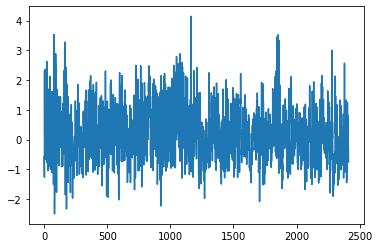

In [393]:
plt.plot(y_competition)

## Using compareTwo just as comparator and compare each sample to the rest!

In [544]:
bigger_than_ranks  = []
modelnn.eval()

for index1, embed1 in enumerate(x_competition_embed_with_ph):
    
    index1_bigger_than = 0
    for index2, embed2 in enumerate(x_competition_embed_with_ph):
        if index1 == index2:
            continue
        difference = compareTwo(embed1, embed2)  * 100 # if negative: embed1>embed2 and if positive embed1<embed2
    
        if difference > 0:
            #print("Index {} < Index {}".format(index1, index2))
            pass
        else:
            #print("Index {} > Index {}".format(index1, index2))
            index1_bigger_than += 1

    bigger_than_ranks.append(index1_bigger_than)
    print("Index {} is bigger than {} others".format(index1, index1_bigger_than))
    

Index 0 is bigger than 1615 others
Index 1 is bigger than 1212 others
Index 2 is bigger than 529 others
Index 3 is bigger than 1362 others
Index 4 is bigger than 345 others
Index 5 is bigger than 639 others
Index 6 is bigger than 10 others
Index 7 is bigger than 2182 others
Index 8 is bigger than 1746 others
Index 9 is bigger than 1836 others
Index 10 is bigger than 1836 others
Index 11 is bigger than 2369 others
Index 12 is bigger than 1847 others
Index 13 is bigger than 1541 others
Index 14 is bigger than 11 others
Index 15 is bigger than 7 others
Index 16 is bigger than 2187 others
Index 17 is bigger than 4 others
Index 18 is bigger than 481 others
Index 19 is bigger than 2092 others
Index 20 is bigger than 1385 others
Index 21 is bigger than 2123 others
Index 22 is bigger than 1128 others
Index 23 is bigger than 1990 others
Index 24 is bigger than 29 others
Index 25 is bigger than 615 others
Index 26 is bigger than 1241 others
Index 27 is bigger than 2333 others
Index 28 is bigger 

Index 228 is bigger than 1645 others
Index 229 is bigger than 771 others
Index 230 is bigger than 1218 others
Index 231 is bigger than 1487 others
Index 232 is bigger than 1296 others
Index 233 is bigger than 1592 others
Index 234 is bigger than 1530 others
Index 235 is bigger than 1001 others
Index 236 is bigger than 1238 others
Index 237 is bigger than 503 others
Index 238 is bigger than 726 others
Index 239 is bigger than 791 others
Index 240 is bigger than 925 others
Index 241 is bigger than 535 others
Index 242 is bigger than 1841 others
Index 243 is bigger than 1273 others
Index 244 is bigger than 820 others
Index 245 is bigger than 1135 others
Index 246 is bigger than 1031 others
Index 247 is bigger than 2146 others
Index 248 is bigger than 1046 others
Index 249 is bigger than 1146 others
Index 250 is bigger than 1567 others
Index 251 is bigger than 1323 others
Index 252 is bigger than 1101 others
Index 253 is bigger than 659 others
Index 254 is bigger than 1098 others
Index 255

Index 453 is bigger than 1164 others
Index 454 is bigger than 1761 others
Index 455 is bigger than 2127 others
Index 456 is bigger than 1310 others
Index 457 is bigger than 321 others
Index 458 is bigger than 1795 others
Index 459 is bigger than 1732 others
Index 460 is bigger than 355 others
Index 461 is bigger than 1670 others
Index 462 is bigger than 1768 others
Index 463 is bigger than 239 others
Index 464 is bigger than 872 others
Index 465 is bigger than 587 others
Index 466 is bigger than 2009 others
Index 467 is bigger than 782 others
Index 468 is bigger than 530 others
Index 469 is bigger than 2153 others
Index 470 is bigger than 1652 others
Index 471 is bigger than 1788 others
Index 472 is bigger than 111 others
Index 473 is bigger than 159 others
Index 474 is bigger than 333 others
Index 475 is bigger than 298 others
Index 476 is bigger than 693 others
Index 477 is bigger than 1678 others
Index 478 is bigger than 760 others
Index 479 is bigger than 334 others
Index 480 is bi

Index 678 is bigger than 1666 others
Index 679 is bigger than 2070 others
Index 680 is bigger than 2360 others
Index 681 is bigger than 676 others
Index 682 is bigger than 62 others
Index 683 is bigger than 1489 others
Index 684 is bigger than 332 others
Index 685 is bigger than 1853 others
Index 686 is bigger than 1642 others
Index 687 is bigger than 1921 others
Index 688 is bigger than 1817 others
Index 689 is bigger than 2291 others
Index 690 is bigger than 77 others
Index 691 is bigger than 854 others
Index 692 is bigger than 693 others
Index 693 is bigger than 722 others
Index 694 is bigger than 1182 others
Index 695 is bigger than 1921 others
Index 696 is bigger than 739 others
Index 697 is bigger than 803 others
Index 698 is bigger than 807 others
Index 699 is bigger than 1826 others
Index 700 is bigger than 1445 others
Index 701 is bigger than 795 others
Index 702 is bigger than 1893 others
Index 703 is bigger than 1230 others
Index 704 is bigger than 959 others
Index 705 is bi

Index 902 is bigger than 583 others
Index 903 is bigger than 1933 others
Index 904 is bigger than 1084 others
Index 905 is bigger than 1504 others
Index 906 is bigger than 2202 others
Index 907 is bigger than 1930 others
Index 908 is bigger than 52 others
Index 909 is bigger than 1042 others
Index 910 is bigger than 324 others
Index 911 is bigger than 1110 others
Index 912 is bigger than 774 others
Index 913 is bigger than 1322 others
Index 914 is bigger than 784 others
Index 915 is bigger than 1898 others
Index 916 is bigger than 2205 others
Index 917 is bigger than 1300 others
Index 918 is bigger than 1318 others
Index 919 is bigger than 546 others
Index 920 is bigger than 1087 others
Index 921 is bigger than 93 others
Index 922 is bigger than 663 others
Index 923 is bigger than 283 others
Index 924 is bigger than 44 others
Index 925 is bigger than 570 others
Index 926 is bigger than 301 others
Index 927 is bigger than 814 others
Index 928 is bigger than 2150 others
Index 929 is bigg

Index 1122 is bigger than 2060 others
Index 1123 is bigger than 2022 others
Index 1124 is bigger than 1920 others
Index 1125 is bigger than 1384 others
Index 1126 is bigger than 674 others
Index 1127 is bigger than 1989 others
Index 1128 is bigger than 2388 others
Index 1129 is bigger than 884 others
Index 1130 is bigger than 2104 others
Index 1131 is bigger than 2358 others
Index 1132 is bigger than 1670 others
Index 1133 is bigger than 944 others
Index 1134 is bigger than 1006 others
Index 1135 is bigger than 1173 others
Index 1136 is bigger than 1873 others
Index 1137 is bigger than 1507 others
Index 1138 is bigger than 962 others
Index 1139 is bigger than 962 others
Index 1140 is bigger than 2164 others
Index 1141 is bigger than 1465 others
Index 1142 is bigger than 2107 others
Index 1143 is bigger than 1777 others
Index 1144 is bigger than 1573 others
Index 1145 is bigger than 719 others
Index 1146 is bigger than 574 others
Index 1147 is bigger than 705 others
Index 1148 is bigger

Index 1341 is bigger than 214 others
Index 1342 is bigger than 1933 others
Index 1343 is bigger than 1996 others
Index 1344 is bigger than 1027 others
Index 1345 is bigger than 2326 others
Index 1346 is bigger than 2266 others
Index 1347 is bigger than 1954 others
Index 1348 is bigger than 1040 others
Index 1349 is bigger than 1862 others
Index 1350 is bigger than 1614 others
Index 1351 is bigger than 1548 others
Index 1352 is bigger than 2036 others
Index 1353 is bigger than 1907 others
Index 1354 is bigger than 1639 others
Index 1355 is bigger than 1675 others
Index 1356 is bigger than 1070 others
Index 1357 is bigger than 39 others
Index 1358 is bigger than 1015 others
Index 1359 is bigger than 673 others
Index 1360 is bigger than 459 others
Index 1361 is bigger than 988 others
Index 1362 is bigger than 405 others
Index 1363 is bigger than 2273 others
Index 1364 is bigger than 1483 others
Index 1365 is bigger than 2211 others
Index 1366 is bigger than 2288 others
Index 1367 is bigge

Index 1559 is bigger than 1838 others
Index 1560 is bigger than 2001 others
Index 1561 is bigger than 1509 others
Index 1562 is bigger than 1767 others
Index 1563 is bigger than 1807 others
Index 1564 is bigger than 788 others
Index 1565 is bigger than 660 others
Index 1566 is bigger than 1766 others
Index 1567 is bigger than 1257 others
Index 1568 is bigger than 1074 others
Index 1569 is bigger than 1417 others
Index 1570 is bigger than 455 others
Index 1571 is bigger than 827 others
Index 1572 is bigger than 1257 others
Index 1573 is bigger than 710 others
Index 1574 is bigger than 1024 others
Index 1575 is bigger than 858 others
Index 1576 is bigger than 284 others
Index 1577 is bigger than 2317 others
Index 1578 is bigger than 379 others
Index 1579 is bigger than 1556 others
Index 1580 is bigger than 2317 others
Index 1581 is bigger than 1604 others
Index 1582 is bigger than 852 others
Index 1583 is bigger than 407 others
Index 1584 is bigger than 245 others
Index 1585 is bigger th

Index 1778 is bigger than 1520 others
Index 1779 is bigger than 1281 others
Index 1780 is bigger than 1892 others
Index 1781 is bigger than 1946 others
Index 1782 is bigger than 1837 others
Index 1783 is bigger than 1987 others
Index 1784 is bigger than 2122 others
Index 1785 is bigger than 1314 others
Index 1786 is bigger than 1645 others
Index 1787 is bigger than 1083 others
Index 1788 is bigger than 1636 others
Index 1789 is bigger than 687 others
Index 1790 is bigger than 1218 others
Index 1791 is bigger than 1172 others
Index 1792 is bigger than 2110 others
Index 1793 is bigger than 935 others
Index 1794 is bigger than 919 others
Index 1795 is bigger than 1559 others
Index 1796 is bigger than 979 others
Index 1797 is bigger than 555 others
Index 1798 is bigger than 519 others
Index 1799 is bigger than 1198 others
Index 1800 is bigger than 1805 others
Index 1801 is bigger than 1828 others
Index 1802 is bigger than 1369 others
Index 1803 is bigger than 892 others
Index 1804 is bigge

Index 1996 is bigger than 1253 others
Index 1997 is bigger than 1514 others
Index 1998 is bigger than 1149 others
Index 1999 is bigger than 1123 others
Index 2000 is bigger than 1064 others
Index 2001 is bigger than 1515 others
Index 2002 is bigger than 2108 others
Index 2003 is bigger than 1893 others
Index 2004 is bigger than 1219 others
Index 2005 is bigger than 888 others
Index 2006 is bigger than 1114 others
Index 2007 is bigger than 686 others
Index 2008 is bigger than 312 others
Index 2009 is bigger than 856 others
Index 2010 is bigger than 446 others
Index 2011 is bigger than 258 others
Index 2012 is bigger than 72 others
Index 2013 is bigger than 2061 others
Index 2014 is bigger than 992 others
Index 2015 is bigger than 435 others
Index 2016 is bigger than 1391 others
Index 2017 is bigger than 1407 others
Index 2018 is bigger than 1039 others
Index 2019 is bigger than 1557 others
Index 2020 is bigger than 904 others
Index 2021 is bigger than 905 others
Index 2022 is bigger tha

Index 2215 is bigger than 1152 others
Index 2216 is bigger than 1776 others
Index 2217 is bigger than 1727 others
Index 2218 is bigger than 1981 others
Index 2219 is bigger than 2153 others
Index 2220 is bigger than 1245 others
Index 2221 is bigger than 1846 others
Index 2222 is bigger than 571 others
Index 2223 is bigger than 2313 others
Index 2224 is bigger than 1340 others
Index 2225 is bigger than 671 others
Index 2226 is bigger than 457 others
Index 2227 is bigger than 656 others
Index 2228 is bigger than 1504 others
Index 2229 is bigger than 886 others
Index 2230 is bigger than 1549 others
Index 2231 is bigger than 2192 others
Index 2232 is bigger than 2012 others
Index 2233 is bigger than 497 others
Index 2234 is bigger than 1287 others
Index 2235 is bigger than 1952 others
Index 2236 is bigger than 2025 others
Index 2237 is bigger than 1349 others
Index 2238 is bigger than 1211 others
Index 2239 is bigger than 1541 others
Index 2240 is bigger than 640 others
Index 2241 is bigge

In [545]:
bigger_than_ranks

[1615,
 1212,
 529,
 1362,
 345,
 639,
 10,
 2182,
 1746,
 1836,
 1836,
 2369,
 1847,
 1541,
 11,
 7,
 2187,
 4,
 481,
 2092,
 1385,
 2123,
 1128,
 1990,
 29,
 615,
 1241,
 2333,
 34,
 1137,
 86,
 340,
 802,
 496,
 108,
 1473,
 1032,
 1142,
 465,
 319,
 1804,
 2336,
 30,
 413,
 525,
 421,
 2093,
 808,
 51,
 171,
 463,
 274,
 22,
 591,
 643,
 804,
 359,
 570,
 1188,
 762,
 2232,
 168,
 829,
 74,
 1033,
 1005,
 130,
 1717,
 652,
 295,
 472,
 2241,
 110,
 609,
 165,
 343,
 1058,
 1029,
 1883,
 1388,
 2277,
 250,
 1056,
 1265,
 451,
 1064,
 211,
 549,
 549,
 210,
 230,
 2387,
 2086,
 91,
 555,
 1765,
 312,
 1741,
 122,
 180,
 1639,
 1171,
 1347,
 2212,
 1614,
 947,
 112,
 269,
 552,
 1147,
 427,
 961,
 1405,
 891,
 842,
 1088,
 2217,
 1070,
 1543,
 410,
 1895,
 1032,
 962,
 274,
 1639,
 1186,
 438,
 785,
 1153,
 2278,
 1251,
 1672,
 2095,
 885,
 429,
 1133,
 1290,
 1612,
 91,
 1261,
 1325,
 1501,
 580,
 1483,
 1001,
 1583,
 516,
 1380,
 569,
 2145,
 1608,
 1606,
 424,
 1337,
 360,
 744,
 1

In [546]:
sortedIndex = np.argsort(bigger_than_ranks)

In [547]:
sortedIndex

array([ 556,  552,  553, ...,  728,  526, 1096], dtype=int64)

In [548]:
sortedIndex.shape

(2413,)

In [549]:
copy = np.empty(sortedIndex.shape[0])
copy[:] = -1 

In [550]:
np.min(copy), np.max(copy)

(-1.0, -1.0)

In [551]:
copy.shape

(2413,)

In [552]:
val = 0
for order in sortedIndex:
    copy[order] = val
    val += 1

In [553]:
for index, rank in enumerate(copy):
    #print(rank)
    if rank == -1:
        print(index)
    
    if rank == 0:
        print('Index {} is bigger than {} other samples.'.format(index, rank))
    
    if rank == sortedIndex.shape[0] - 1:
        print('Index {} is bigger than {} other samples.'.format(index, rank))

Index 556 is bigger than 0.0 other samples.
Index 1096 is bigger than 2412.0 other samples.


In [554]:
np.min(copy), np.max(copy)

(0.0, 2412.0)

# Pick the approach and submit for score

In [555]:
y_competition = copy

In [556]:
y_competition

array([1614., 1213.,  529., ..., 1439., 1575.,  117.])

In [557]:
competition_tm = [((y * 80 / 2412) + 20) for y in y_competition]

In [558]:
competition_tm

[73.53233830845771,
 60.23217247097844,
 37.54560530679934,
 65.2072968490879,
 31.376451077943614,
 41.1608623548922,
 20.33167495854063,
 92.43781094527363,
 77.87728026533998,
 80.79601990049751,
 80.86235489220564,
 98.54063018242122,
 81.35986733001658,
 71.17744610281923,
 20.364842454394694,
 20.23217247097844,
 92.57048092868989,
 20.132669983416253,
 35.88723051409619,
 89.35323383084577,
 65.8374792703151,
 90.38142620232172,
 57.41293532338308,
 86.00331674958541,
 20.928689883913766,
 40.36484245439469,
 61.19402985074627,
 97.41293532338308,
 21.094527363184078,
 57.5787728026534,
 22.819237147595356,
 31.144278606965173,
 46.533996683250415,
 36.48424543946932,
 23.582089552238806,
 68.85572139303483,
 54.16252072968491,
 57.74461028192371,
 35.456053067993366,
 30.547263681592042,
 79.76782752902156,
 97.51243781094527,
 20.961857379767828,
 33.698175787728026,
 37.41293532338308,
 33.96351575456053,
 89.38640132669984,
 46.79933665008292,
 21.65837479270315,
 25.6716417

In [559]:
submission = pd.read_csv("./proteindata/sample_submission.csv")

In [560]:
submission

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4
...,...,...
2408,33798,2408
2409,33799,2409
2410,33800,2410
2411,33801,2411


In [561]:
competition_tm_round = [round(x, 0) for x in competition_tm]
competition_tm_round

[74.0,
 60.0,
 38.0,
 65.0,
 31.0,
 41.0,
 20.0,
 92.0,
 78.0,
 81.0,
 81.0,
 99.0,
 81.0,
 71.0,
 20.0,
 20.0,
 93.0,
 20.0,
 36.0,
 89.0,
 66.0,
 90.0,
 57.0,
 86.0,
 21.0,
 40.0,
 61.0,
 97.0,
 21.0,
 58.0,
 23.0,
 31.0,
 47.0,
 36.0,
 24.0,
 69.0,
 54.0,
 58.0,
 35.0,
 31.0,
 80.0,
 98.0,
 21.0,
 34.0,
 37.0,
 34.0,
 89.0,
 47.0,
 22.0,
 26.0,
 35.0,
 29.0,
 21.0,
 40.0,
 41.0,
 47.0,
 32.0,
 39.0,
 59.0,
 45.0,
 94.0,
 26.0,
 48.0,
 22.0,
 54.0,
 53.0,
 24.0,
 77.0,
 42.0,
 30.0,
 36.0,
 94.0,
 24.0,
 40.0,
 25.0,
 31.0,
 55.0,
 54.0,
 82.0,
 66.0,
 96.0,
 28.0,
 55.0,
 62.0,
 35.0,
 55.0,
 27.0,
 38.0,
 38.0,
 27.0,
 28.0,
 99.0,
 89.0,
 23.0,
 38.0,
 79.0,
 30.0,
 78.0,
 24.0,
 26.0,
 74.0,
 59.0,
 65.0,
 93.0,
 73.0,
 51.0,
 24.0,
 29.0,
 38.0,
 58.0,
 34.0,
 52.0,
 67.0,
 50.0,
 48.0,
 56.0,
 94.0,
 55.0,
 71.0,
 34.0,
 83.0,
 54.0,
 52.0,
 29.0,
 74.0,
 59.0,
 35.0,
 46.0,
 58.0,
 96.0,
 61.0,
 75.0,
 89.0,
 49.0,
 34.0,
 58.0,
 63.0,
 73.0,
 23.0,
 62.0,
 64.0,
 70.0,
 39.0,

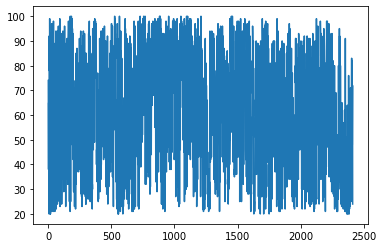

In [562]:
plt.plot(competition_tm_round)

In [563]:
submission['tm'] = competition_tm_round

In [564]:
filename_submission = "./proteindata/submission_0102_v6_ranksC.csv"

In [565]:
submission.to_csv(filename_submission, index = False)

In [566]:
!kaggle competitions submit -c novozymes-enzyme-stability-prediction -f "./proteindata/submission_0102_v6_ranksC.csv" -m Comparator

Successfully submitted to Novozymes Enzyme Stability Prediction



  0%|          | 0.00/28.3k [00:00<?, ?B/s]
100%|##########| 28.3k/28.3k [00:02<00:00, 13.2kB/s]


In [567]:
!kaggle competitions submissions -c novozymes-enzyme-stability-prediction 

fileName                          date                 description    status    publicScore  privateScore  
--------------------------------  -------------------  -------------  --------  -----------  ------------  
submission_0102_v6_ranksC.csv     2023-01-03 03:56:24  Comparator     complete  0.018                      
submission_0102_v5_ranksC.csv     2023-01-03 00:33:38  Comparator     complete  0.045                      
submission_0102_v4_ranksC.csv     2023-01-03 00:31:45  Comparator     complete  0.045                      
submission_0102_v3_ranks.csv      2023-01-02 13:16:12  wildComp       complete  0.045                      
submission_0102_v2.csv            2023-01-02 11:22:35  wildComp       complete  0.043                      
submission_0102_v1.csv            2023-01-02 11:03:10  goodSplit      complete  0.016                      
submission_0101_v3.csv            2023-01-02 04:27:30  Stra_DualReg   complete  0.015                      
submission_0101_v2.csv      